# Opportunities@MeLi - Code Exercise - Data Scientist

## Description:
In the context of Mercadolibre's Marketplace an algorithm is needed to predict if an item listed in the marketplace is new or used.

Your tasks involve the data analysis, designing, processing and modeling of a machine learning solution to predict if an item is new or used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k_checked_v3.jsonlines` and a function `build_dataset` to read that dataset in `new_or_used.py`.

For the evaluation, you will use the accuracy metric in order to get a result of 0.86 as minimum. Additionally, you will have to choose an appropriate secondary metric and also elaborate an argument on why that metric was chosen.

The deliverables are:
* The file, including all the code needed to define and evaluate a model.
* A document with an explanation on the criteria applied to choose the features, the proposed secondary metric and the performance achieved on that metrics. Optionally, you can deliver an EDA analysis with other format like .ipynb


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json


# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def cantidad_distintos_nulo(df,col):
    val = (~df[col].isna()).sum()
    print("valores distintos de null: {}".format(val))
    print("porcentaje de no nulos: {}".format(val/df.shape[0])) 
    
    
def bar_plot_binarios(df,col,col_target=None, is_target=False):
    
    if is_target:
        gr_col = df.groupby([col])[["id"]].count().reset_index()
        gr_col["pct"] = gr_col["id"]/gr_col["id"].sum()

        n_cols = 1
        n_rows = 1

        fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*10, n_cols*6))        
        display(gr_col)        
        sns.barplot(gr_col, x=col, y="id", hue=col, legend=True, ax=ax)
    else:
        gr_condition = df.groupby([col,col_target])[["id"]].count().reset_index()
        gr_condition["pct"] = gr_condition["id"]/gr_condition.groupby(col)["id"].transform("sum")
        gr_col = gr_condition.groupby([col])[["id"]].sum().reset_index()
        gr_col["pct"] = gr_col["id"]/gr_col["id"].sum()

        n_cols = 1
        n_rows = 2

        fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*10, n_cols*6))
        axs=ax.flatten()

        display(gr_col)
        display(gr_condition)

        sns.barplot(gr_col, x=col, y="id", hue=col, legend=True, ax=axs[0])
        sns.barplot(gr_condition, x=col, y="pct", hue=col_target, legend=True, ax=axs[1])


def desc_continuous(df,col,col_target):
    print(df[col].isna().sum())
    desc_df_col = df[[col]].describe().T
    desc_df_target = df.groupby(col_target)[[col]].describe()

    display(desc_df_col)
    display(desc_df_target)

    n_rows = 2
    n_cols = 2

    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*10, n_rows*6))
    axs = ax.flatten()

    sns.kdeplot(data=df, x=col, ax=axs[0])
    sns.kdeplot(data=np.log(df[col]), ax=axs[1])
    sns.kdeplot(data=df, x=col, hue=col_target, ax=axs[2])

    df_dummy = df[[col,col_target]]
    df_dummy.loc[:,col] = np.log(df_dummy[col])

    sns.kdeplot(data=df_dummy,x=col, hue=col_target, ax=axs[3])
    axs[0].set_title("distribucion variable {}".format(col))
    axs[1].set_title("distribucion variable {} - log transformacion".format(col))
    axs[2].set_title("distribucion variable {} con variable objetivo".format(col,col_target))
    axs[3].set_title("distribucion variable {} con variable objetivo {} - log transformacion".format(col,col_target))
    
    
def explore_json_column(df,col):
    print((df[col].str.len() > 0).sum())
    df_json = df.loc[df[col].str.len() > 0,col].\
                                explode(col).\
                                reset_index()

    df_json = pd.json_normalize(df_json[col])
    return df_json


def valida_contenido_json(df,col, limit=0):
    val = (df[col].str.len() > limit).sum()
    print("cantidad de elementos con datos {}".format(val))
    print("porcentaje de elemetos con datos {}".format(val/df.shape[0]))

In [3]:
X_train, y_train, X_test, y_test = build_dataset()

In [4]:
df = pd.json_normalize(X_train, sep='_')
print(df.shape)
print(df.columns.values)
pd.DataFrame(df.columns).to_csv("columnas_meli2.csv",sep=";", index=False)

(90000, 92)
['warranty' 'sub_status' 'condition' 'seller_contact' 'deal_ids'
 'base_price' 'non_mercado_pago_payment_methods' 'seller_id' 'variations'
 'site_id' 'listing_type_id' 'price' 'attributes' 'buying_mode' 'tags'
 'listing_source' 'parent_item_id' 'coverage_areas' 'category_id'
 'descriptions' 'last_updated' 'international_delivery_mode' 'pictures'
 'id' 'official_store_id' 'differential_pricing' 'accepts_mercadopago'
 'original_price' 'currency_id' 'thumbnail' 'title' 'automatic_relist'
 'date_created' 'secure_thumbnail' 'stop_time' 'status' 'video_id'
 'catalog_product_id' 'subtitle' 'initial_quantity' 'start_time'
 'permalink' 'sold_quantity' 'available_quantity' 'seller_address_comment'
 'seller_address_longitude' 'seller_address_id'
 'seller_address_country_name' 'seller_address_country_id'
 'seller_address_address_line' 'seller_address_latitude'
 'seller_address_search_location_neighborhood_name'
 'seller_address_search_location_neighborhood_id'
 'seller_address_search_l

In [5]:
new_cols = ['seller_contact',
'seller_address_comment',
'seller_address_longitude',
'seller_address_id',
'seller_address_address_line',
'seller_address_latitude',
'seller_address_search_location_neighborhood_name',
'seller_address_search_location_neighborhood_id',
'seller_address_search_location_state_name',
'seller_address_search_location_state_id',
'seller_address_search_location_city_name',
'seller_address_search_location_city_id',
'seller_address_zip_code',
'geolocation_latitude',
'geolocation_longitude',
'seller_contact_area_code2',
'seller_contact_phone2',
'seller_contact_webpage',
'seller_contact_email',
'seller_contact_contact',
'seller_contact_area_code',
'seller_contact_other_info',
'seller_contact_phone',
'location_open_hours',
'location_neighborhood_name',
'location_neighborhood_id',
'location_longitude',
'location_country_name',
'location_country_id',
'location_address_line',
'location_latitude',
'location_zip_code',
'location_city_name',
'location_city_id',
'location_state_name',
'location_state_id',
]

In [9]:
df[new_cols].apply(lambda col: cantidad_distintos_nulo(df, col.name))

valores distintos de null: 0
porcentaje de no nulos: 0.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 90000
porcentaje de no nulos: 1.0
valores distintos de null: 1982
porcentaje de no nulos: 0.02202222222222222
valores disti

seller_contact                                      None
seller_address_comment                              None
seller_address_longitude                            None
seller_address_id                                   None
seller_address_address_line                         None
seller_address_latitude                             None
seller_address_search_location_neighborhood_name    None
seller_address_search_location_neighborhood_id      None
seller_address_search_location_state_name           None
seller_address_search_location_state_id             None
seller_address_search_location_city_name            None
seller_address_search_location_city_id              None
seller_address_zip_code                             None
geolocation_latitude                                None
geolocation_longitude                               None
seller_contact_area_code2                           None
seller_contact_phone2                               None
seller_contact_webpage         

## Descartar variables a priori
Luego de ver la estructura del Json se identifican las siguientes columnas como candidatas a eliminar a priori

In [10]:
cols_unique = ["seller_id",
"site_id",
"id",
"thumbnail",
"secure_thumbnail",
"stop_time",
"start_time",
"permalink",
"video_id",
"seller_address_id",
"seller_address_search_location_state_id",
"seller_address_search_location_city_id",
"location_neighborhood_id",
"location_country_id",
"location_city_id",
"location_state_id"
]

df[cols_unique].nunique()

seller_id                                  33282
site_id                                        1
id                                         90000
thumbnail                                  88227
secure_thumbnail                           88227
stop_time                                  78486
start_time                                 78890
permalink                                  90000
video_id                                    1886
seller_address_id                          33289
seller_address_search_location_state_id       29
seller_address_search_location_city_id       303
location_neighborhood_id                     481
location_country_id                            1
location_city_id                             171
location_state_id                             30
dtype: int64


eliminar:
* site_id : no da valor ya que es un unico valor 
* secure_thumbnail: se asume que se tendra la misma informacion que el thumbnail
* stop_time: se asume que no tiene relacion alguna con la caracteristica del elemento
* permalink: no da valor es un valor unico para cada registro 
* location_country_id: no da valir ya que es un valor unico

**atencion** 

id se eliminara para el analisis final, pero se mantendra para el EDA con el fin de enriquecer la informacion
* id : no da valor efectivamente es un id unico en esta base

In [ ]:
del_cols = ["site_id","secure_thumbnail","stop_time","permalink","location_country_id"]
df_EDA = df.drop(columns=del_cols)
print(df_EDA.shape)
df_EDA.columns.values

(90000, 52)


array(['warranty', 'sub_status', 'condition', 'deal_ids', 'base_price',
       'non_mercado_pago_payment_methods', 'seller_id', 'variations',
       'listing_type_id', 'price', 'attributes', 'buying_mode', 'tags',
       'listing_source', 'parent_item_id', 'coverage_areas',
       'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id',
       'official_store_id', 'differential_pricing', 'accepts_mercadopago',
       'original_price', 'currency_id', 'thumbnail', 'title',
       'automatic_relist', 'date_created', 'status', 'video_id',
       'catalog_product_id', 'subtitle', 'initial_quantity', 'start_time',
       'sold_quantity', 'available_quantity',
       'seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id',
       'shipping_local_pick_up', 'shipping_methods', 'shipping_tags',
       'shipping_free_shipping'

## Manejo de Missing values
en esta seccion se analizaran los datos que tienen missing values o que por su estructura del json no fueron leidas efectivamente

In [84]:
df_isna = pd.DataFrame(df_EDA.isna().sum()/df_EDA.shape[0])
df_isna[df_isna.fillna(0)>0.5].dropna()

,0
warranty,0.608411
official_store_id,0.991722
differential_pricing,1.000000
original_price,0.998556
video_id,0.970267
catalog_product_id,0.999922
subtitle,1.000000
shipping_dimensions,0.999756
shipping_free_methods,0.970122


**warranty**

Candidata a analisis NLP, sin embargo inicialmente se modelara binaria, cuyo valor indicara si tiene texto de garantía 1 (warranty) o no 0

In [85]:
cantidad_distintos_nulo(df_EDA,"warranty")
df_EDA.loc[~df_EDA["warranty"].isna(),"warranty"].head(10)

valores distintos de null: 35243
porcentaje de no nulos: 0.3915888888888889


1                            NUESTRA REPUTACION
4                                MI REPUTACION.
5                                            Sí
8                                         1 Ano
12                          VACIOS sin utilizar
16                 Se ve en el dia de la compra
20    100% de acuerdo a descripcion e imagenes.
26                     Sí. Librería a la calle.
27                                           Sí
30                           Mis calificaciones
Name: warranty, dtype: object

**official_store_id**

Se asume que es un identificador para tiendas oficiales por lo que se manejara como un binario, indicando si tiene la marca de tienda oficial 1 o 0 de lo contrario

In [86]:
cantidad_distintos_nulo(df_EDA,"official_store_id")
df_EDA["official_store_id"].unique()

valores distintos de null: 745
porcentaje de no nulos: 0.008277777777777778


array([  nan, 7410., 7705., 9218., 9391., 1650., 1350., 8665., 5020.,
       7819., 6415., 3590., 8702., 5450., 8558., 5192., 1580., 4701.,
       6732., 6158., 2658., 6550., 1024., 1330., 9317., 4273., 5752.,
       4198., 5685., 2503., 2396., 2666., 9933., 8649., 7076., 9555.,
       9566., 2429., 4832., 3716., 7088., 4511., 3649., 6043., 3431.,
       2186., 8293., 9137., 9906., 1315., 7248., 6923., 7673., 8755.,
       6450., 6477., 2422., 2255., 1044., 7220., 4666., 5355., 3220.,
       6448., 1056., 7533., 3879., 7181., 1957., 5870., 9338., 3635.,
       9343., 2810., 1847., 5755., 5718., 6910., 7208., 9156., 3279.,
       3825., 4888., 5133., 8537., 7408., 8407., 9971., 3234., 7646.,
       2348., 4112., 5872., 8594., 9729., 5492., 9875., 1607., 9703.,
       5265., 3496., 4472., 6429., 9720., 8705., 9189., 9934., 7802.,
       6003., 7172., 8680., 4892., 2057., 9309., 7121., 9069., 5409.,
       2905., 1123., 9698., 4825., 8711., 6106., 9542., 7532., 4206.,
       6302., 3719.,

**differential_pricing**

todos son nulos, drop

In [87]:
(~df_EDA["differential_pricing"].isna()).sum()

0

**Original Price**

puede ser que una diferencia entre este y el precio del dataset indique un descuento o aumento del valor, por lo que se creara una variable nueva que indique:

- 0: cuando no existe el dato base price o no hay variacion
- 1: si el precio actual es mayor al precio base
- -1: si el precio actual es menor al precio base
 
posteriormente se eliminara esta variable de precio original

In [88]:
df_EDA.loc[~df_EDA["original_price"].isna(),["original_price","price","base_price"]]
cantidad_distintos_nulo(df_EDA,"original_price")

#transformacion
df_EDA["variation_original_price"] = (np.sign(df_EDA["price"]  - df_EDA["original_price"])).fillna(0)

valores distintos de null: 130
porcentaje de no nulos: 0.0014444444444444444


**video_id**

se asume que es un codigo que no aporta valor, sin embargo se dejara como caracteristica binaria si tiene video 1 o 0 de lo contrario

In [89]:
cantidad_distintos_nulo(df_EDA,"video_id")
df_EDA.loc[~df_EDA["video_id"].isna(),["video_id"]].head(10)

valores distintos de null: 2676
porcentaje de no nulos: 0.029733333333333334


,video_id
8,QQNfOicE_o8
51,upGjgXun-lU
112,YDvSXmSHKKE
150,QQNfOicE_o8
171,FyEJiX4Ufak
172,W6jRsA2Yf5k
178,cC3Scp65U80
217,7xGwqauqhGY
223,QnLPIw8ynro
224,CpZGmVDUELg


**catalog_product_id**

solo existen 7 valores distintos de nulo por lo que se decide eliminar ya que no daria valor al modelo

In [90]:
cantidad_distintos_nulo(df_EDA,"catalog_product_id")
df_EDA.loc[~df_EDA["catalog_product_id"].isna(),["catalog_product_id"]].head(10)

valores distintos de null: 7
porcentaje de no nulos: 7.777777777777778e-05


,catalog_product_id
2702,800744.0
5124,5093232.0
5220,3050291.0
24318,5126117.0
34469,94404.0
44087,3051112.0
48758,3053998.0


**subtitle**

todas son nulas no da valor, drop

In [91]:
cantidad_distintos_nulo(df_EDA,"subtitle")

valores distintos de null: 0
porcentaje de no nulos: 0.0


**shipping_dimensions**

existen 22 valores no nulos, y dadas sus caracteristicas se elimina a priori ya que no se considera que de valor al modelo

In [92]:
cantidad_distintos_nulo(df_EDA,"shipping_dimensions")
df_EDA.loc[~df_EDA["shipping_dimensions"].isna(),["shipping_dimensions"]].head(10)

valores distintos de null: 22
porcentaje de no nulos: 0.00024444444444444443


,shipping_dimensions
961,"5x25x25,150"
9675,"33x20x12,80"
10448,"30x30x30,650"
14955,"33x20x12,500"
31910,"33x20x12,400"
38585,"33x20x12,1000"
39560,"10x10x20,700"
42249,"33x20x12,400"
44276,"33x20x12,300"
44766,"30x30x30,650"


**shipping_free_methods**

json no procesado, luego de desglosar no se ven variables contenidas que sean de valor, adicional la existencia de **shipping_free_shipping** indica que esta caracteristica puede estar repetida en esta variable, por lo que se elimina

In [93]:
cantidad_distintos_nulo(df_EDA,"shipping_free_methods")

valores distintos de null: 2689
porcentaje de no nulos: 0.029877777777777777


In [94]:
df_shipping_free_methods = df_EDA.loc[~df_EDA["shipping_free_methods"].isna(),["id","shipping_free_methods"]].explode("shipping_free_methods")

pd.json_normalize(df_shipping_free_methods["shipping_free_methods"]).nunique()

id                4
rule.value        0
rule.free_mode    1
dtype: int64

#### resumen missing values

Las siguientes variables serán transformadas en valores binarios de 1 existencia de un valor y 0 cuando no existe
- warranty
- official_store_id
- video_id

Las siguientes columnas se eliminaran:
- differential_pricing
- catalog_product_id
- subtitle
- shipping_dimensions
- shipping_free_methods

Las siguientes columnas tendran transformaciones
- original_price: se encontrara el signo de la resta entre (price - original_price) si es negativo el valor será -1, 0 si la diferencia es 0 o si es nulo y 1 en caso de que la diferencia sea positiva

In [95]:
# Transformaciones por analisis nulo

del_cols = ["differential_pricing",
            "catalog_product_id",
            "subtitle",
            "shipping_dimensions"]
df_EDA = df_EDA.drop(columns=del_cols)

print(df_EDA.shape)

(90000, 49)


In [96]:
binary_cols = ["warranty",
               "official_store_id",
               "video_id"]

df_EDA[binary_cols] = (~df_EDA[binary_cols].isna()).astype(int)

In [97]:
df_EDA["variation__original_price"] = (np.sign(df_EDA["price"]  - df_EDA["original_price"])).fillna(0)
df_EDA = df_EDA.drop(columns="original_price")

## EDA

### Variable Objetivo
condition, puede ser transformada para hacerla un problema de clasificacion binario, se puede decir que el set es balanceado

,condition,id,pct
0,new,48352,0.537244
1,used,41648,0.462756


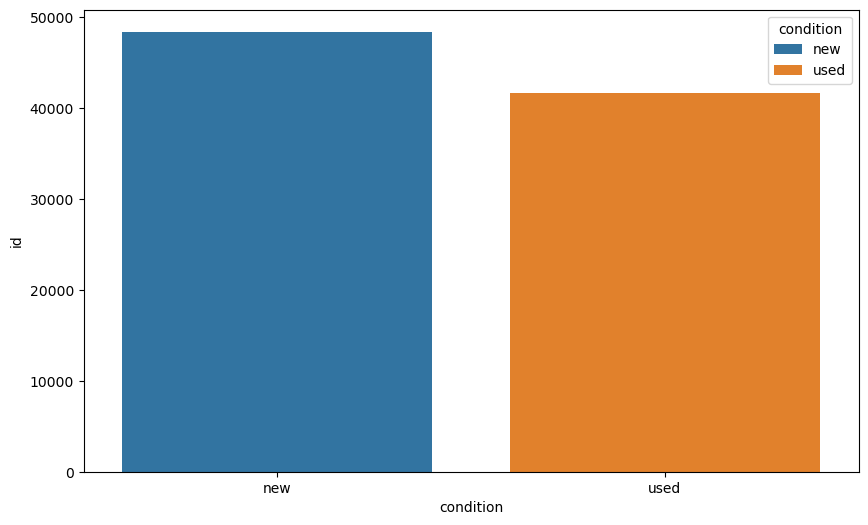

In [98]:
bar_plot_binarios(df_EDA,"condition",is_target=True)
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)
df_EDA["binary_new"] = (df_EDA["condition"] == "new").astype(int)

**warranty**

ya fue procesada para ser transformada en binario antes y este es su resultado

0


,warranty,id,pct
0,0,54757,0.608411
1,1,35243,0.391589


,warranty,condition,id,pct
0,0,new,26475,0.483500
1,0,used,28282,0.516500
2,1,new,21877,0.620747
3,1,used,13366,0.379253


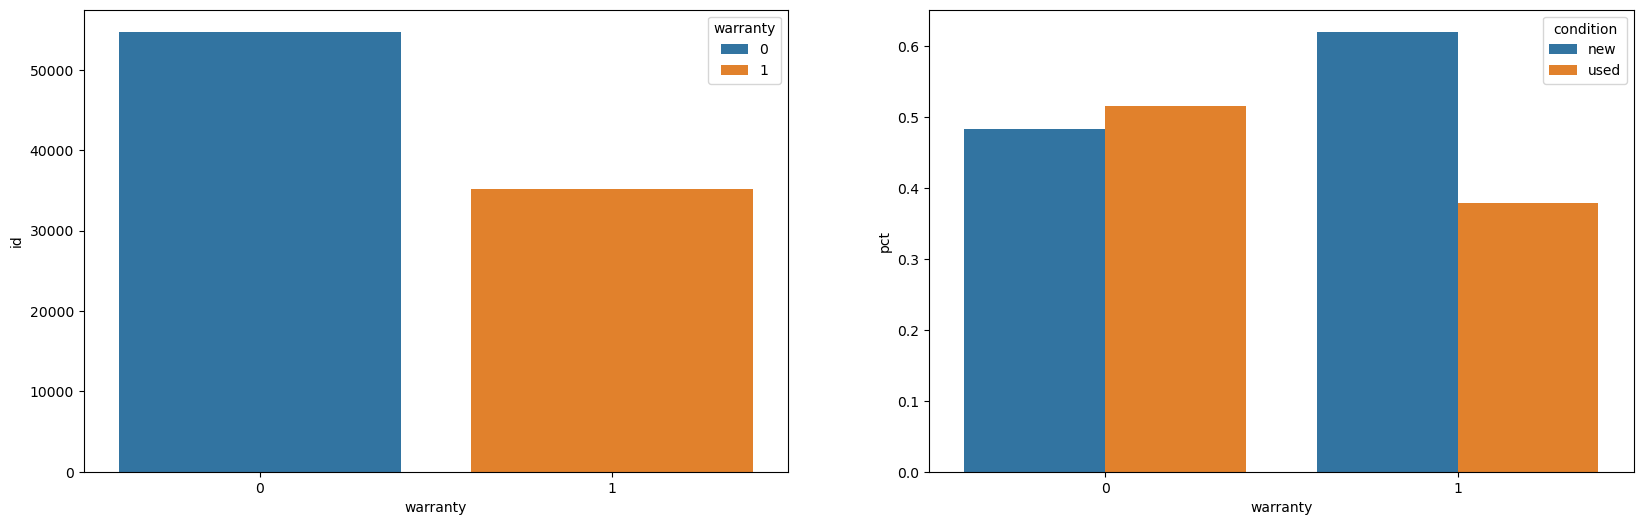

In [99]:
print(df_EDA["warranty"].isna().sum())
bar_plot_binarios(df_EDA,"warranty","condition")

**sub_status**

se encuentran que estos son los valores almacenados en esta variable: 'suspended', 'expired', 'deleted', se determina que esta informacion no seria importante para determinar el tipo de elemento vendido ya que se considera que es un estado de la venta "posterior" a la publicacion

In [100]:
cantidad_distintos_nulo(df_EDA,"sub_status")
valida_contenido_json(df_EDA,"sub_status")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 891
porcentaje de elemetos con datos 0.0099


In [101]:
col = "sub_status"
df_EDA.loc[df_EDA[col].str.len() > 0,col].str[0].unique()

array(['suspended', 'expired', 'deleted'], dtype=object)

**deal_ids**

despues de validar se encuentra que son menor a 0.2% la cantidad de registros que contienen informacion, adicionalmente la informacion son codigos que no añaden valor al modelo, por lo que se decide eliminar

In [102]:
cantidad_distintos_nulo(df_EDA,"deal_ids")
valida_contenido_json(df_EDA,"deal_ids")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 217
porcentaje de elemetos con datos 0.0024111111111111113


In [103]:
col = "deal_ids"
df_EDA.loc[df_EDA[col].str.len() > 0,col].str[0].unique()

array(['15H9O', 'JXLIQ', 'LZFND', 'WGPLA', 'MOSH6', 'BBLRY', 'ABQ1I',
       'PPW2S', 'MISCR', 'CHMGI', 'ZZMKC', 'WO4YE', 'UKXWI', '7FOQD',
       'YOLH8', 'UUINF', 'R99GD', 'Y3MPW', 'GAC6A', 'AZEBL', 'GRMWV',
       'ZZHBN', '805OS', 'VYYJI', 'SI7I0', 'QXDHA', 'W40QU', 'UQU1U',
       'F9G6U', 'CULNX'], dtype=object)

**base_price**

mantener, al comparar la variable vs la variable **price** se encuentra que para el set de datos esta siempre se menor, por lo que 
por lo que se creara una variable nueva que indique:

$$
 \text{base\_price} -\text{price}
$$

- 0: cuando no existe el dato base price o no hay variacion
- 1: si el precio actual es mayor al precio base
- -1: si el precio actual es menor al precio base
 
posteriormente se eliminara esta variable de base_price

In [104]:
# analisis particular de la variable
cantidad_distintos_nulo(df_EDA,"base_price")
print("cantidad valores diferentes :{}".format((df_EDA["base_price"] == df_EDA["price"]).sum()))
print("cantidad de valores donde price < base_price")
print(((df_EDA["price"] - df_EDA["base_price"]) < 0).sum())
print("cantidad de valores donde price > base_price")
print(((df_EDA["price"] - df_EDA["base_price"]) > 0).sum())

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad valores diferentes :89974
cantidad de valores donde price < base_price
0
cantidad de valores donde price > base_price
26


0


,count,mean,std,min,25%,50%,75%,max
base_price,90000.0,57813.408189,9.089555e+06,0.84,90.0,250.0,800.0,2.222222e+09


base_price                                                  \
               count          mean           std   min    25%    50%   
condition                                                              
new          48352.0  49672.213300  1.010629e+07  0.84  140.0  350.0   
used         41648.0  67265.075862  7.743572e+06  1.00   65.0  150.0   

                                   
                75%           max  
condition                          
new        995.1125  2.222222e+09  
used       546.2200  1.111111e+09

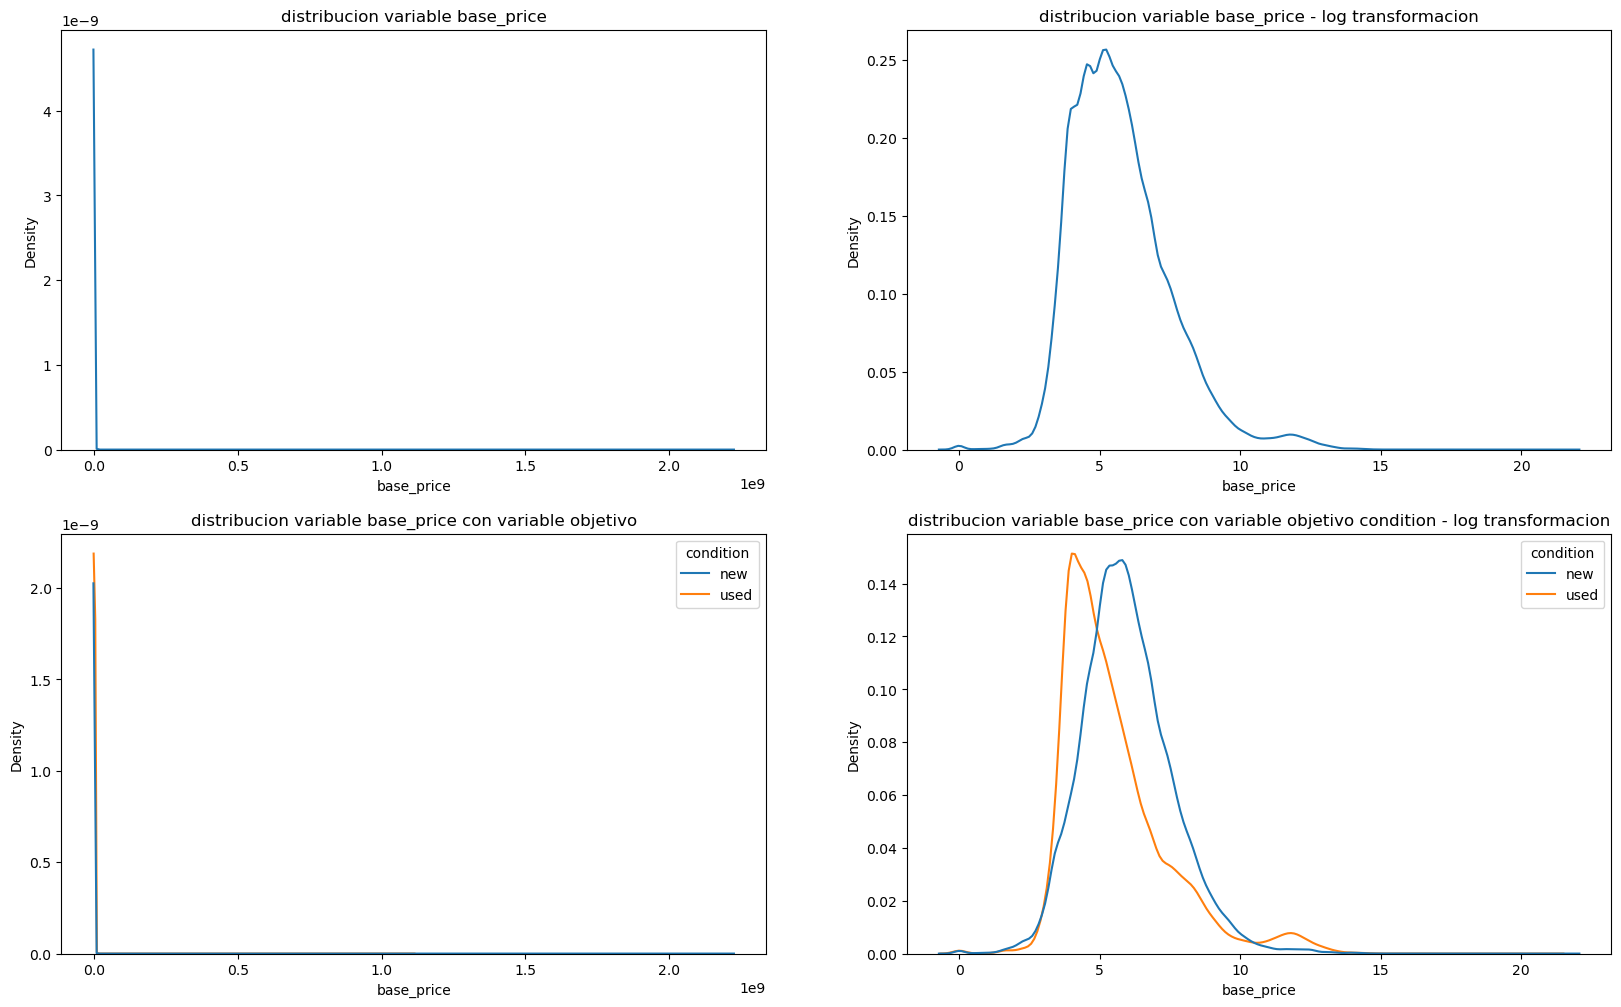

In [105]:
desc_continuous(df_EDA,"base_price","condition")

In [106]:
#transformacion
df_EDA["variation_base_price"] = (np.sign(df_EDA["price"]  - df_EDA["base_price"])).fillna(0)

,variation_base_price,id,pct
0,0.0,89974,0.999711
1,1.0,26,0.000289


,variation_base_price,condition,id,pct
0,0.0,new,48337,0.537233
1,0.0,used,41637,0.462767
2,1.0,new,15,0.576923
3,1.0,used,11,0.423077


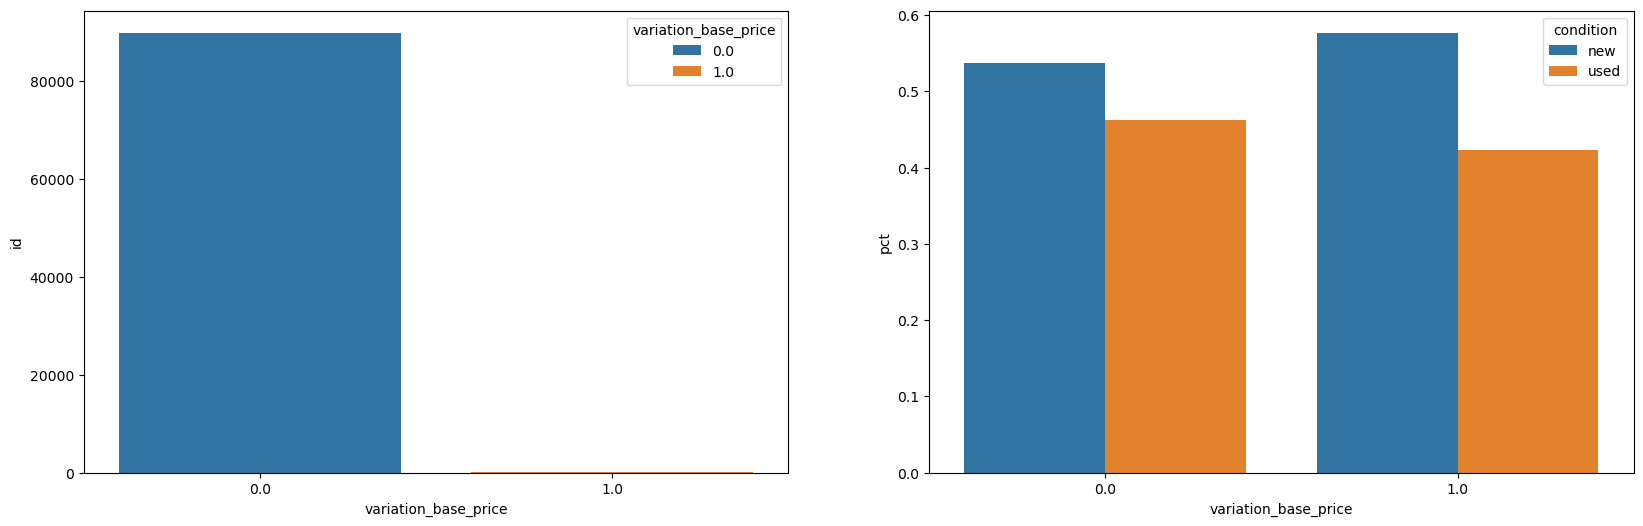

In [107]:
bar_plot_binarios(df_EDA,"variation_base_price","condition")

**non_mercado_pago_payment_methods**

esta columna tiene mas informacion contenida a traves de un json.

Al analizar la columna se ve que un producto puede tener mas de un metodo de pago, se procesan los datos para enriquecer la base con la informacion contenida en el json,
se establecen dos variables a partir de este campo.

- cantidad de metodos de pago: corresponde al conteo de metodos de pago contenidos en el json
- tipo de medio de pago: se caracterizan los medios de pago presentes y se establece la siguiente asignacion

| Método de Pago            | Código               |
|---------------------------|----------------------|
| Acordar con el comprador  | efectivo_o_acuerdo   |
| Efectivo                  | efectivo_o_acuerdo   |
| Transferencia bancaria    | transferencia_bancaria |
| Giro postal               | giro_postal          |
| Cheque certificado        | cheque               |
| American Express          | tarjeta_credito      |
| Diners                    | tarjeta_credito      |
| MasterCard                | tarjeta_credito      |
| Mastercard Maestro        | tarjeta_credito      |
| Visa                      | tarjeta_credito      |
| Visa Electron             | tarjeta_credito      |
| Tarjeta de crédito        | tarjeta_credito      |
| MercadoPago               | MercadoPago          |
| Contra reembolso          | contra_reembolso     |


In [108]:
cantidad_distintos_nulo(df_EDA,"non_mercado_pago_payment_methods")
valida_contenido_json(df_EDA,"non_mercado_pago_payment_methods")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 62469
porcentaje de elemetos con datos 0.6941


In [109]:
# cantidad de metodos de pago
df_EDA["non_mercado_pago_payment_methods"].str.len().head(5)

0    3
1    2
2    3
3    3
4    3
Name: non_mercado_pago_payment_methods, dtype: int64

In [110]:
df_shipping_free_methods = df_EDA.loc[:,["id","non_mercado_pago_payment_methods"]].\
                            explode("non_mercado_pago_payment_methods").\
                            reset_index()

df_shipping_free_methods_explode = pd.json_normalize(df_shipping_free_methods["non_mercado_pago_payment_methods"])
df_shipping_free_methods_explode.rename(columns={"description":"description_shipping_free_methods",
                                                 "id":"id_shipping_free_methods"},
                                        inplace=True)

df_shipping_free_methods = pd.concat([df_shipping_free_methods[["id"]], 
                                      df_shipping_free_methods_explode], 
                                      axis=1)[["id","description_shipping_free_methods","id_shipping_free_methods"]]

df_shipping_free_methods.groupby(["description_shipping_free_methods","id_shipping_free_methods"])[["id"]].count()
df_shipping_free_methods.groupby(["description_shipping_free_methods"])[["id"]].count()


,id
description_shipping_free_methods,
Acordar con el comprador,7175
American Express,533
Cheque certificado,412
Contra reembolso,570
Diners,413
Efectivo,60350
Giro postal,1489
MasterCard,572
Mastercard Maestro,557


In [111]:
dict_metodos_de_pago = {
    "Acordar con el comprador": "efectivo_o_acuerdo",
    "Efectivo": "efectivo_o_acuerdo",
    "Transferencia bancaria": "transferencia_bancaria",
    "Giro postal": "giro_postal",
    "Cheque certificado": "cheque",
    "American Express": "tarjeta_credito",
    "Diners": "tarjeta_credito",
    "MasterCard": "tarjeta_credito",
    "Mastercard Maestro": "tarjeta_credito",
    "Visa": "tarjeta_credito",
    "Visa Electron": "tarjeta_credito",
    "Tarjeta de crédito": "tarjeta_credito",
    "MercadoPago": "MercadoPago",
    "Contra reembolso": "contra_reembolso"
}
df_shipping_free_methods["metodo_de_pago"] = df_shipping_free_methods["description_shipping_free_methods"].map(dict_metodos_de_pago)
df_shipping_free_methods["ones"] = 1
gr_shipping_free_methods = df_shipping_free_methods.groupby(["id","metodo_de_pago"])[["ones"]].sum().reset_index()
#df_shipping_free_methods = df_shipping_free_methods.drop_duplicates()
gr_shipping_free_methods = gr_shipping_free_methods.pivot(index="id",columns="metodo_de_pago", values="ones").fillna(0)


pd.merge(df, gr_shipping_free_methods, on="id", how="left")

,warranty,sub_status,condition,deal_ids,base_price,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,...,shipping_mode,shipping_dimensions,shipping_free_methods,MercadoPago,cheque,contra_reembolso,efectivo_o_acuerdo,giro_postal,tarjeta_credito,transferencia_bancaria
0,None,[],new,[],80.00,"[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,...,not_specified,None,NaN,0.0,0.0,0.0,2.0,0.0,0.0,1.0
1,NUESTRA REPUTACION,[],used,[],2650.00,"[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,...,me2,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,None,[],used,[],60.00,"[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,...,me2,None,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,None,[],new,[],580.00,"[{'description': 'Transferencia bancaria', 'id...",5377752182,[],MLA,silver,...,me2,None,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,MI REPUTACION.,[],used,[],30.00,"[{'description': 'Transferencia bancaria', 'id...",2938071313,[],MLA,bronze,...,not_specified,None,NaN,0.0,0.0,0.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,Sin garantía,[],used,[],68.00,[],9451922715,[],MLA,bronze,...,me2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89996,None,[],new,[],126.00,"[{'description': 'Transferencia bancaria', 'id...",4665194056,[],MLA,bronze,...,custom,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
89997,None,[],new,[],300.00,"[{'description': 'Efectivo', 'id': 'MLAMO', 't...",3046474001,[],MLA,bronze,...,not_specified,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
89998,La garantia solo responde en caso de fallas de...,[],new,[],696.58,"[{'description': 'Acordar con el comprador', '...",2373910598,[],MLA,bronze,...,not_specified,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**seller_id**

se puede enriquecer la informacion y crear una metrica que es el % de productos que tiene el vendedor que son usados, esto se realiza con 

para cada cliente:
$$
\text{score seller} = \frac{\text{cantidad de marca condición == used}}{\text{total de productos}}
$$

In [112]:
cantidad_distintos_nulo(df_EDA,"seller_id")
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)
gr_seller_id = df_EDA.groupby(["seller_id"]).agg({"binary_used":"sum","id":"count"}).sort_values(by="binary_used",ascending=False)

gr_seller_id["score_seller_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]
display(gr_seller_id.head(5))
dict_transform_seller_id = gr_seller_id[["score_seller_used"]].to_dict()["score_seller_used"]
dict_transform_seller_id

valores distintos de null: 90000
porcentaje de no nulos: 1.0


,binary_used,id,score_seller_used
seller_id,,,
4631246902,406,408,0.995098
6972484560,256,259,0.988417
8326621157,209,211,0.990521
4248718919,209,244,0.856557
7694743641,168,183,0.918033


{4631246902: 0.9950980392156863,
 6972484560: 0.9884169884169884,
 8326621157: 0.990521327014218,
 4248718919: 0.8565573770491803,
 7694743641: 0.9180327868852459,
 2024252139: 1.0,
 3135396608: 0.9634146341463414,
 6538753635: 0.98125,
 8918336477: 1.0,
 4226059250: 0.9931506849315068,
 6537535599: 0.986013986013986,
 6832522378: 1.0,
 5749908984: 0.9315068493150684,
 8220549814: 0.9926470588235294,
 4838664540: 0.9926470588235294,
 6029888950: 0.9492753623188406,
 3846095764: 1.0,
 4755818264: 1.0,
 7672071434: 0.754601226993865,
 6645536870: 1.0,
 2122542660: 0.9457364341085271,
 8516415845: 0.9918032786885246,
 5255978862: 0.9917355371900827,
 7394214410: 1.0,
 4014611326: 1.0,
 7740664679: 0.9904761904761905,
 4131433201: 1.0,
 1833552445: 1.0,
 6884045011: 0.9326923076923077,
 1097160251: 1.0,
 2810172868: 0.979381443298969,
 3756285952: 0.96875,
 2874645086: 0.9489795918367347,
 3056798548: 0.989247311827957,
 5405099807: 1.0,
 6904497846: 1.0,
 2302325100: 0.9565217391304348,
 

In [113]:
df_EDA["seller_id"].map(dict_transform_seller_id)

0        0.000000
1        1.000000
2        1.000000
3        0.000000
4        1.000000
           ...   
89995    0.785714
89996    0.000000
89997    0.000000
89998    0.000000
89999    1.000000
Name: seller_id, Length: 90000, dtype: float64

**variations**

informacion de variaciones del producto, contiene bastantes datos referentes a cambios del producto ofertado, se decide no ahondar en esta informacion y, se reemplazará por un la cantidad de variaciones contenidas

In [114]:
cantidad_distintos_nulo(df_EDA,"variations")
valida_contenido_json(df_EDA,"variations")

df_variations = df_EDA.loc[df_EDA["variations"].str.len() > 0,"variations"].\
                            explode("variations").\
                            reset_index()

df_variations = pd.json_normalize(df_variations["variations"])
df_variations.head(5)

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 7374
porcentaje de elemetos con datos 0.08193333333333333


,attribute_combinations,seller_custom_field,picture_ids,sold_quantity,available_quantity,id,price
0,"[{'value_id': '92012', 'name': 'Color Primario...",None,"[472901-MLA20442937232_102015, 509801-MLA20442...",0,1,9742952789,180.0
1,"[{'value_id': '92021', 'name': 'Color Primario...",None,"[22802-MLA20237759642_022015, 22826-MLA2023775...",1,1,9720380234,120.0
2,"[{'value_id': '92000', 'name': 'Color Primario...",None,"[908601-MLA20391431364_082015, 817701-MLA20391...",0,1,9338152892,450.0
3,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",1,2,9391988875,590.0
4,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",0,2,9391988878,590.0


In [115]:
df_EDA["variations"].str.len().unique()

array([ 0,  1,  3,  4,  7, 12,  2,  5,  6,  8, 10, 18, 20, 13, 11, 15,  9,
       30, 14, 16, 24, 19, 17, 25, 22, 42, 35, 23, 21, 50, 36, 34],
      dtype=int64)

**listing_type_id**

https://developers.mercadolibre.com.ar/en_us/listing-types-item-upgrades-tutorial
https://developers.mercadolibre.com.ni/es_ar/atributos

categorizacion del cliente, tiene sentido ordinal, por lo que se transformara el texto a valores entre 0 - 6

In [116]:
print(df_EDA["listing_type_id"].unique())

dict_transform_listing_type = {'free':0,
                               'bronze':1,
                               'silver':2,
                               'gold':3, 
                               'gold_premium':4,
                               'gold_special':5, 
                               'gold_pro':6}

['bronze' 'silver' 'free' 'gold_special' 'gold' 'gold_premium' 'gold_pro']


**Price**

mantener variable

0


,count,mean,std,min,25%,50%,75%,max
price,90000.0,57813.518133,9.089555e+06,0.84,90.0,250.0,800.0,2.222222e+09


price                                                            \
             count          mean           std   min    25%    50%       75%   
condition                                                                      
new        48352.0  49672.367141  1.010629e+07  0.84  140.0  350.0  995.5875   
used       41648.0  67265.134845  7.743572e+06  1.00   65.0  150.0  548.2500   

                         
                    max  
condition                
new        2.222222e+09  
used       1.111111e+09

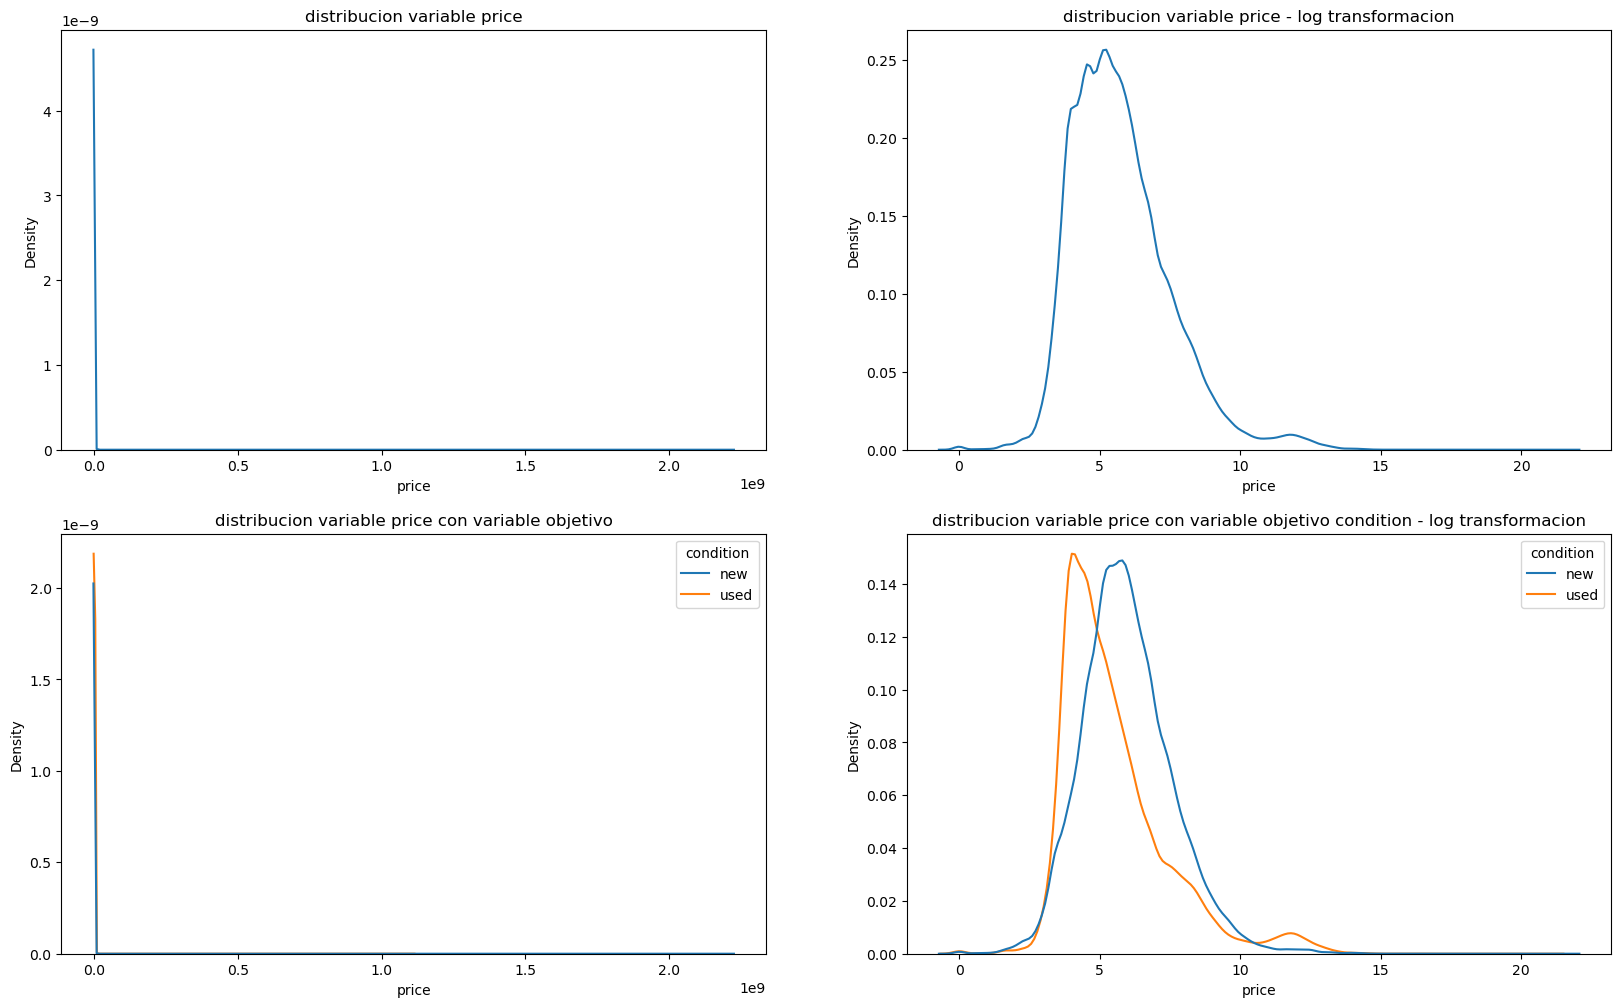

In [117]:
desc_continuous(df_EDA,"price","condition")

**attributes**

informacion de los atributos, tiene bastante informacion y podria explorarse aun mas en una iteracion posterior, 
incialmente se manejara cantidad de atributos como la variable

In [118]:
cantidad_distintos_nulo(df_EDA,"attributes")
valida_contenido_json(df_EDA,"attributes")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 11150
porcentaje de elemetos con datos 0.1238888888888889


In [119]:
explore_json_column(df_EDA,"attributes").head(10)

11150


,value_id,attribute_group_id,name,value_name,attribute_group_name,id
0,,DFLT,Número de pieza,37123,Otros,PART_NUMBER
1,female,DFLT,Género,Mujer,Otros,GENDER
2,Season-Spring-Summer,FIND,Season,Spring-Summer,Ficha técnica,Season
3,,DFLT,Número pieza,2,Otros,MLA-PART_NUMBER
4,female,DFLT,Género,Mujer,Otros,GENDER
5,Season-Spring-Summer,FIND,Season,Spring-Summer,Ficha técnica,Season
6,male,DFLT,Género,Hombre,Otros,GENDER
7,Season-All-Season,FIND,Season,All-Season,Ficha técnica,Season
8,,ADICIONALES,Horario de contacto,09 HS A 19 HS,Adicionales,MLA1743-HORPREF
9,MLA1744-COLOREXT-PLATA,ADICIONALES,Color,Plata,Adicionales,MLA1744-COLOREXT


In [120]:
df_EDA["num_attributes"] = df_EDA["attributes"].str.len()

**buying_mode**

en los porcentajes se observa diferencias entre los tipos de buying modes, se transformara a si es del tipo buy_it_now o no [1,0]

valores distintos de null: 90000
porcentaje de no nulos: 1.0


,buying_mode,id,pct
0,auction,707,0.007856
1,buy_it_now,87311,0.970122
2,classified,1982,0.022022


,buying_mode,condition,id,pct
0,auction,new,228,0.322489
1,auction,used,479,0.677511
2,buy_it_now,new,47669,0.545968
3,buy_it_now,used,39642,0.454032
4,classified,new,455,0.229566
5,classified,used,1527,0.770434


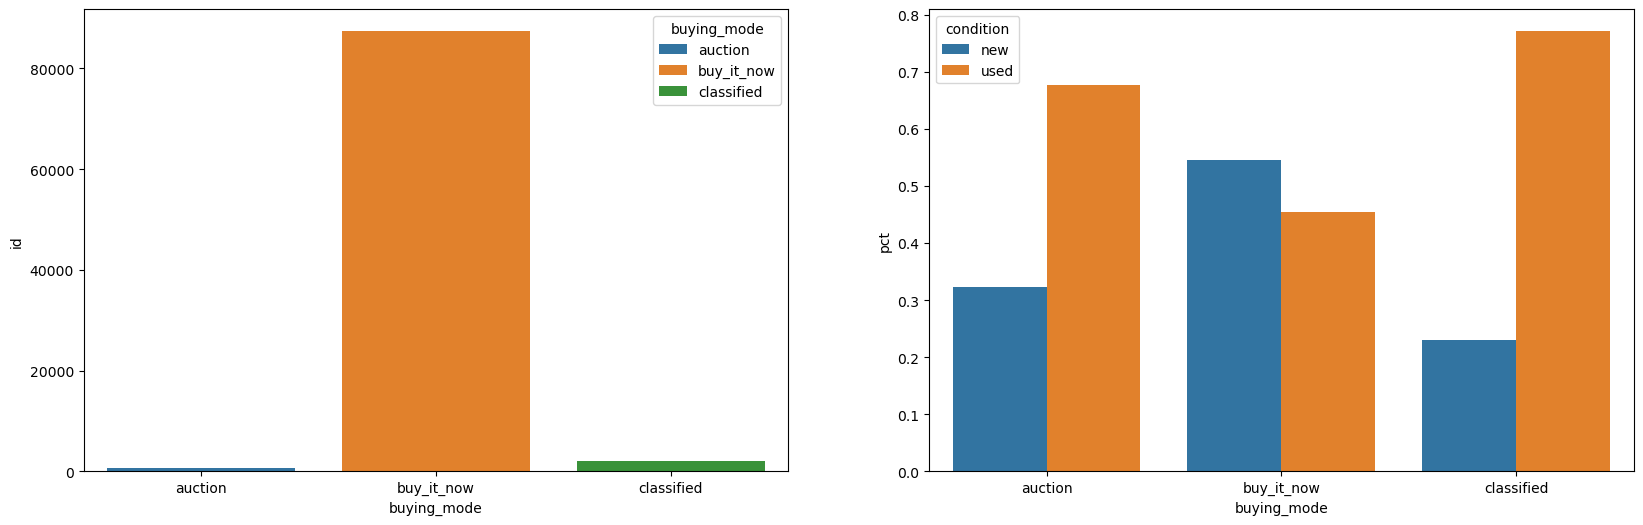

In [121]:
cantidad_distintos_nulo(df_EDA,"buying_mode")
bar_plot_binarios(df_EDA,"buying_mode","condition")

In [122]:
df_EDA["buying_mode"].isin(["buy_it_now"]).astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
89995    1
89996    1
89997    1
89998    1
89999    1
Name: buying_mode, Length: 90000, dtype: int32

**tags**

tiene ciertas caracteristicas para 75% de los datos, se transformara a cantidad de tags de cada fila

https://developers.mercadolibre.cl/es_ar/publica-productos

In [123]:
cantidad_distintos_nulo(df_EDA,"tags")
valida_contenido_json(df_EDA,"tags")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 67588
porcentaje de elemetos con datos 0.7509777777777777


In [124]:
df_EDA.loc[df_EDA["tags"].str.len() > 0,"tags"].\
                                explode("tags").unique()

array(['dragged_bids_and_visits', 'good_quality_thumbnail',
       'dragged_visits', 'free_relist', 'poor_quality_thumbnail'],
      dtype=object)

In [125]:
(df_EDA["tags"].str.len() > 0).sum()

67588

In [126]:
gr = pd.DataFrame(df_EDA.loc[df_EDA["tags"].str.len() > 0,"tags"].\
                                explode("tags")).\
                                groupby("tags").size()

gr/df_EDA.shape[0]

tags
dragged_bids_and_visits    0.739067
dragged_visits             0.008033
free_relist                0.002878
good_quality_thumbnail     0.017078
poor_quality_thumbnail     0.000144
dtype: float64

**listing_source**

no tiene informacion por lo que se decide eliminar

In [127]:
cantidad_distintos_nulo(df_EDA,"listing_source")
valida_contenido_json(df_EDA,"listing_source")
explore_json_column(df_EDA,"listing_source")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 0
porcentaje de elemetos con datos 0.0
0


""


**parent_item_id**

no se analizara el producto con el que tiene relacion sin embargo se conservara la variable como binaria

In [128]:
cantidad_distintos_nulo(df_EDA,"parent_item_id")
valida_contenido_json(df_EDA,"parent_item_id")

valores distintos de null: 69310
porcentaje de no nulos: 0.7701111111111111
cantidad de elementos con datos 69310
porcentaje de elemetos con datos 0.7701111111111111


In [129]:
df_EDA["parent_item_id"]

0        MLA6553902747
1        MLA7727150374
2        MLA6561247998
3                 None
4        MLA3133256685
             ...      
89995    MLA1130924824
89996    MLA1317691731
89997    MLA5098165723
89998    MLA3153148762
89999    MLA3661010119
Name: parent_item_id, Length: 90000, dtype: object

**coverage_areas**

tiene informacion como listas pero al validar se encuentra que estan vaicas, eliminar

In [130]:
#(df_EDA["coverage_areas"].str.len() > 0).sum()
cantidad_distintos_nulo(df_EDA,"coverage_areas")
valida_contenido_json(df_EDA,"coverage_areas")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 0
porcentaje de elemetos con datos 0.0


**category_id**

no se tiene detalle de cada categoria, adicionalmente se cuenta con mas de 10k categorias transformar tratar estos datos de forma categorica induciria a una gran cantidad de datos, por este motivo se decide crear un score de popularidad, todos referenciados a la max categoria

$$
\text{score category id popularity} = \frac{\text{cantidad de elementos en la categoria}} {\text{cantidad productos categoria mas popular}}
$$

$$
\text{score category id} = \frac{\text{cantidad de elementos en la categoria == used}} {\text{cantidad productos categoria mas popular}}
$$

In [131]:
#print(df_EDA["category_id"].isna().sum())
cantidad_distintos_nulo(df_EDA,"category_id")
gr_category_id = df_EDA.groupby("category_id")[["id"]].count().sort_values("id",ascending=False)
gr_category_id = gr_category_id/gr_category_id.max()
print("cantidad de categorias: {}".format(gr_category_id.shape[0]))
gr_category_id.to_dict()["id"]

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de categorias: 10491


{'MLA1227': 1.0,
 'MLA2044': 0.42498187968108236,
 'MLA41287': 0.20028992510268182,
 'MLA3530': 0.16549891278086495,
 'MLA2038': 0.14520415559313843,
 'MLA15171': 0.12611741966658613,
 'MLA15328': 0.10775549649673834,
 'MLA1383': 0.10050736892969317,
 'MLA41269': 0.09640009664170089,
 'MLA15204': 0.09543367963276153,
 'MLA3361': 0.0939840541193525,
 'MLA2032': 0.09325924136264799,
 'MLA85960': 0.08311186276878473,
 'MLA41064': 0.0804542159942015,
 'MLA119287': 0.07972940323749698,
 'MLA6651': 0.0780381734718531,
 'MLA1963': 0.0748973181928002,
 'MLA41185': 0.06958202464363372,
 'MLA26536': 0.06958202464363372,
 'MLA3936': 0.06789079487798985,
 'MLA60611': 0.06644116936458082,
 'MLA4335': 0.06305870983329306,
 'MLA41174': 0.06209229282435371,
 'MLA41260': 0.06160908431988403,
 'MLA41083': 0.06112587581541435,
 'MLA15226': 0.06064266731094467,
 'MLA5496': 0.056535395022952406,
 'MLA11456': 0.05581058226624789,
 'MLA1207': 0.05532737376177821,
 'MLA352293': 0.05411935250060401,
 'MLA40497

In [132]:
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)
gr_category_id = df_EDA.groupby("category_id").agg({"id":"count","binary_used":"sum"}).sort_values("id",ascending=False)
gr_category_id["score_category_id"] = gr_category_id["binary_used"]/gr_category_id["id"]
gr_category_id["score_popularity"] = gr_category_id["id"]/gr_category_id["id"].max()
print("cantidad de categorias: {}".format(gr_category_id.shape[0]))
#gr_category_id.to_dict()["id"]
gr_category_id

# gr_seller_id = df_EDA.groupby(["seller_id"]).agg({"binary_used":"sum","id":"count"}).sort_values(by="binary_used",ascending=False)

# gr_seller_id["score_seller_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]
# display(gr_seller_id.head(5))
# dict_transform_seller_id = gr_seller_id[["score_seller_used"]].to_dict()["score_seller_used"]
# dict_transform_seller_id

cantidad de categorias: 10491


,id,binary_used,score_category_id,score_popularity
category_id,,,,
MLA1227,4139,2100,0.507369,1.000000
MLA2044,1759,1327,0.754406,0.424982
MLA41287,829,719,0.867310,0.200290
MLA3530,685,269,0.392701,0.165499
MLA2038,601,570,0.948419,0.145204
...,...,...,...,...
MLA336868,1,0,0.000000,0.000242
MLA59361,1,0,0.000000,0.000242
MLA336514,1,0,0.000000,0.000242


**descriptions**

los datos son codigos que no se consideran aportan valor al modelo, con la informacion actual

In [133]:
col = "descriptions"

cantidad_distintos_nulo(df_EDA,col)
valida_contenido_json(df_EDA,col)

(df_EDA[col].str.len() > 1).sum()
df_EDA.loc[df_EDA[col].str.len() > 0,col].\
                                explode(col)

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 87583
porcentaje de elemetos con datos 0.9731444444444445


0        {'id': 'MLA4695330653-912855983'}
1        {'id': 'MLA7160447179-930764806'}
2        {'id': 'MLA7367189936-916478256'}
3        {'id': 'MLA9191625553-932309698'}
4        {'id': 'MLA7787961817-902981678'}
                       ...                
87578    {'id': 'MLA1315520302-935540165'}
87579    {'id': 'MLA6934377054-927516382'}
87580    {'id': 'MLA5644559490-902956215'}
87581    {'id': 'MLA3520244075-935837959'}
87582    {'id': 'MLA8241142190-943040617'}
Name: descriptions, Length: 87583, dtype: object

**last_updated**

fechas no se conoce cuando se extrajo la data, podria extrapolarse a la fecha maxima y referenciar los valores a este.

sin embargo incialmente se descarta

In [134]:
df_EDA["last_updated"].describe()

count                        90000
unique                       86015
top       2015-09-30T12:20:39.000Z
freq                             6
Name: last_updated, dtype: object

**international_delivery_mode**

unico valor, no aporta al modelo se descarta

In [135]:
cantidad_distintos_nulo(df_EDA,"international_delivery_mode")
valida_contenido_json(df_EDA,"international_delivery_mode")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 90000
porcentaje de elemetos con datos 1.0


In [136]:
df_EDA["international_delivery_mode"].unique()

array(['none'], dtype=object)

**pictures**

contiene informacion de la foto, sin embargo de dichos campos no se extraera informacion, quizas el max tamaño de la foto pudiese dar informacion pero se decide cambiar la informacion a: la cantidad de fotos que tiene cada producto

In [137]:
cantidad_distintos_nulo(df_EDA,"pictures")
valida_contenido_json(df_EDA,"pictures")
explore_json_column(df_EDA,"pictures")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 89297
porcentaje de elemetos con datos 0.9921888888888889
89297


,size,secure_url,max_size,url,quality,id
0,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,,5386-MLA4695330653_052013
1,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5361-MLA469533065...,,5361-MLA4695330653_052013
2,499x334,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,951x637,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,,23223-MLA7160447179_022015
3,500x375,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1024x768,http://mla-s2-p.mlstatic.com/23273-MLA71604471...,,23273-MLA7160447179_022015
4,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1024x768,http://mla-s1-p.mlstatic.com/23205-MLA71604471...,,23205-MLA7160447179_022015
...,...,...,...,...,...,...
263724,225x225,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,225x225,http://mla-s2-p.mlstatic.com/4664-MLA352024407...,,4664-MLA3520244075_022013
263725,500x281,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1200x675,http://mla-s2-p.mlstatic.com/716501-MLA8241142...,,716501-MLA8241142190_082015
263726,500x281,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1200x675,http://mla-s2-p.mlstatic.com/410601-MLA8241142...,,410601-MLA8241142190_082015
263727,281x500,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,675x1200,http://mla-s1-p.mlstatic.com/439501-MLA8241142...,,439501-MLA8241142190_082015


In [138]:
df_EDA["pictures"].str.len()

0        2
1        6
2        1
3        2
4        2
        ..
89995    1
89996    3
89997    1
89998    1
89999    4
Name: pictures, Length: 90000, dtype: int64

**official_store_id**

ya fue binarizado arriba

,official_store_id,id,pct
0,0,89255,0.991722
1,1,745,0.008278


,official_store_id,condition,id,pct
0,0,new,47628,0.533617
1,0,used,41627,0.466383
2,1,new,724,0.971812
3,1,used,21,0.028188


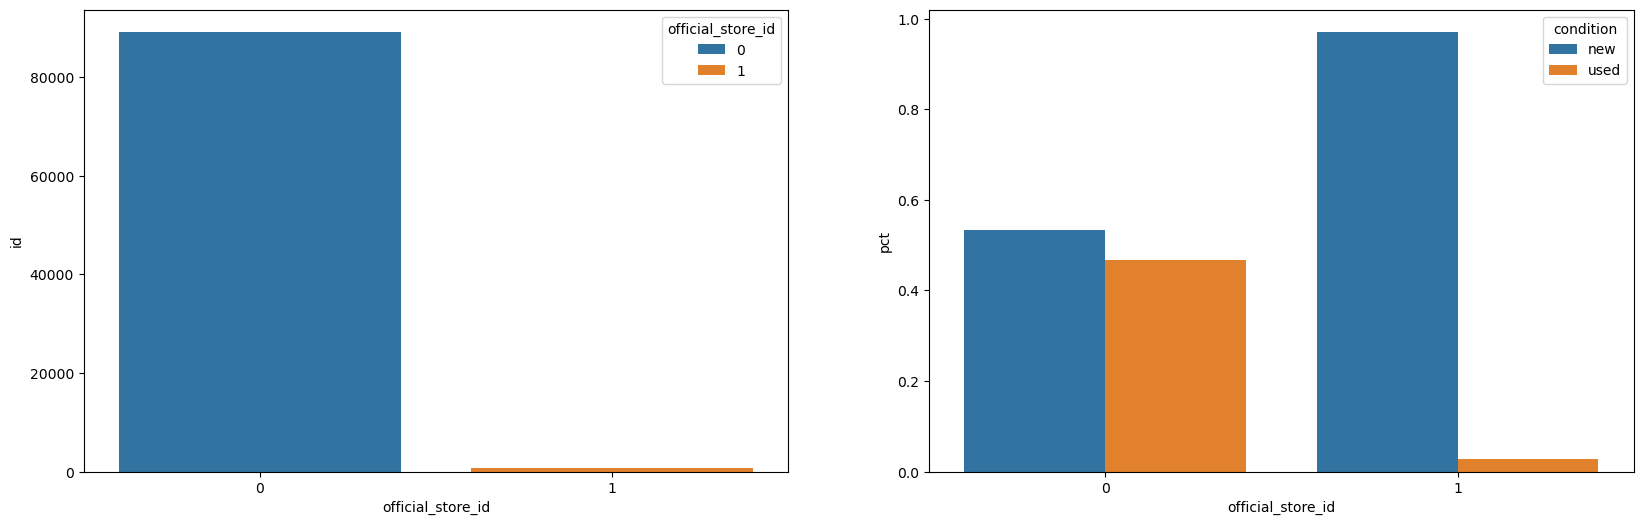

In [139]:
bar_plot_binarios(df_EDA,"official_store_id","condition")

**accepts_mercadopago**

se convierte a numerico

,accepts_mercadopago,id,pct
0,False,1982,0.022022
1,True,88018,0.977978


,accepts_mercadopago,condition,id,pct
0,False,new,455,0.229566
1,False,used,1527,0.770434
2,True,new,47897,0.544173
3,True,used,40121,0.455827


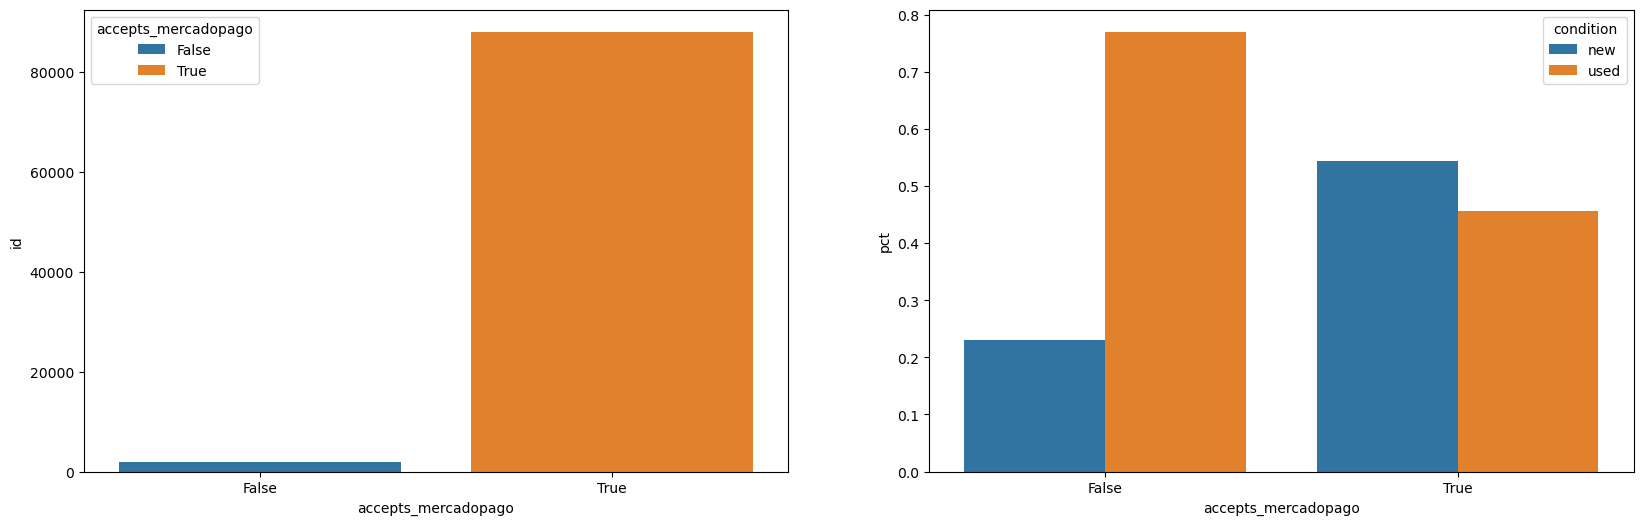

In [140]:
bar_plot_binarios(df_EDA,"accepts_mercadopago","condition")

In [141]:
df_EDA["accepts_mercadopago"] = df_EDA["accepts_mercadopago"].astype(int)

**original_price**

ya fue tratado arriba, se transformo en una nueva variable

valores distintos de null: 90000
porcentaje de no nulos: 1.0


,variation__original_price,id,pct
0,-1.0,127,0.001411
1,0.0,89873,0.998589


,variation__original_price,condition,id,pct
0,-1.0,new,127,1.000000
1,0.0,new,48225,0.536591
2,0.0,used,41648,0.463409


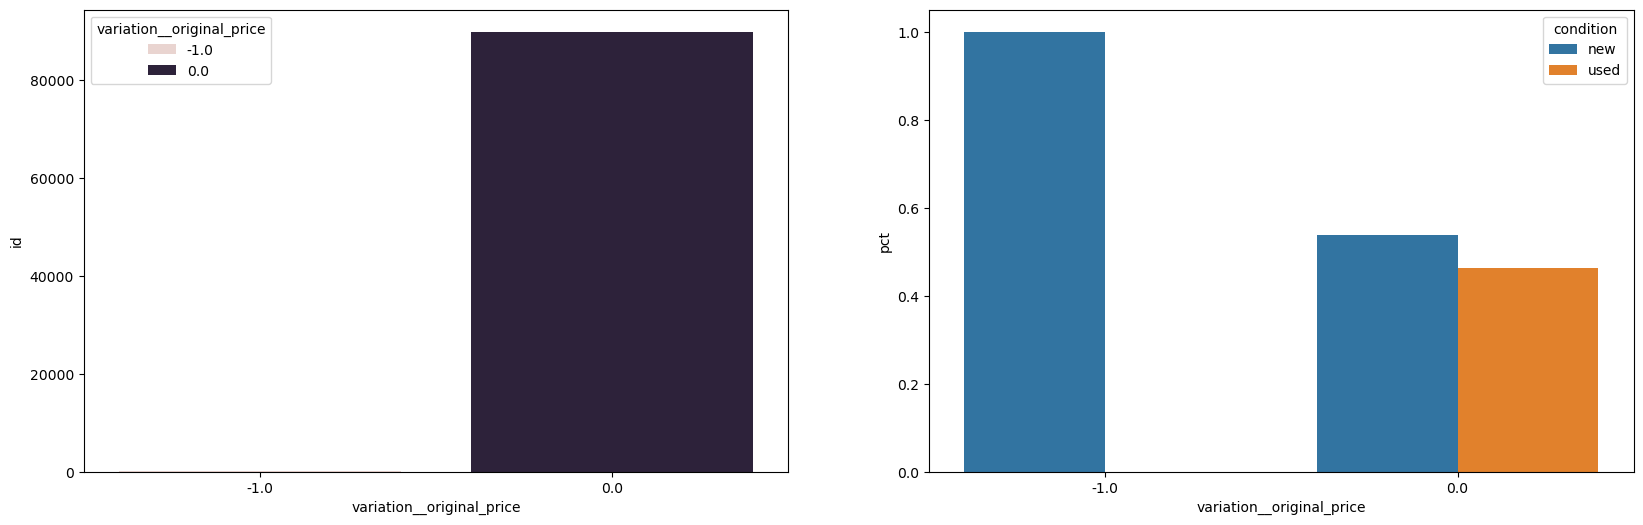

In [144]:
cantidad_distintos_nulo(df_EDA,"variation__original_price")
bar_plot_binarios(df_EDA,"variation__original_price","condition")

**currency_id**

mas del 99% de los datos pertenece a una unica categoria, se descarta la variable por ser poco representativa

0


,currency_id,id,pct
0,ARS,89496,0.9944
1,USD,504,0.0056


,currency_id,condition,id,pct
0,ARS,new,48165,0.538180
1,ARS,used,41331,0.461820
2,USD,new,187,0.371032
3,USD,used,317,0.628968


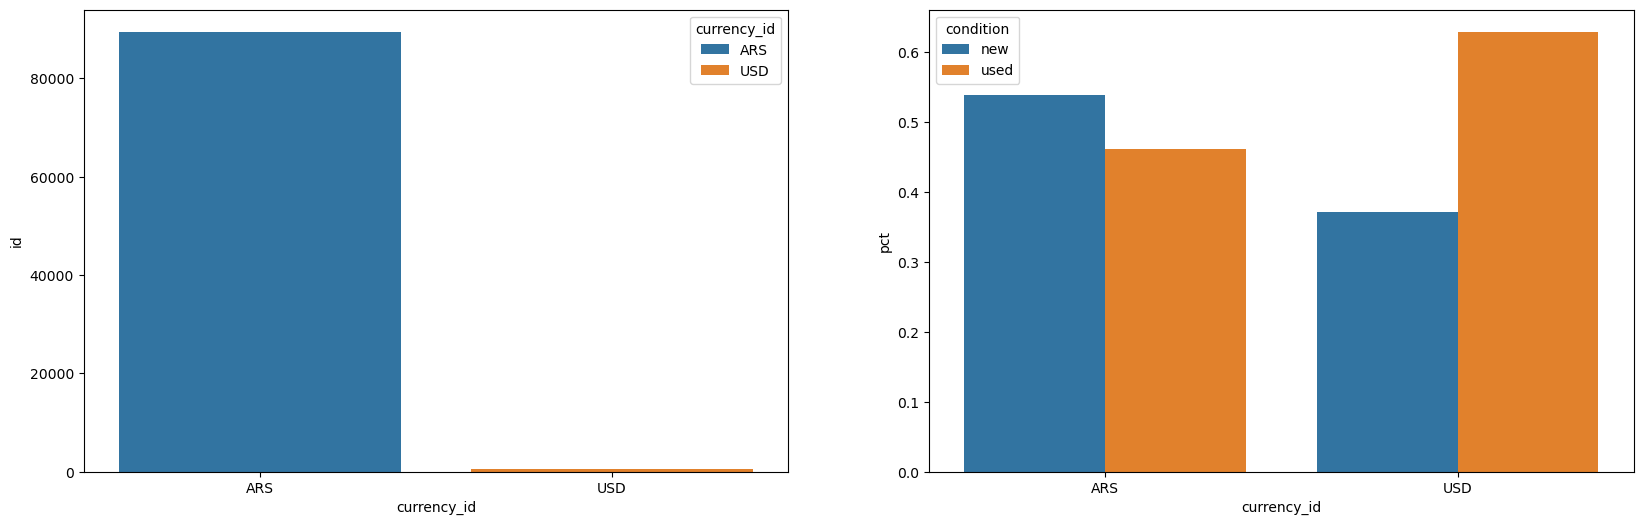

In [145]:
col = "currency_id"
print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

**title**

tiene informacion que puede ser procesada con un NLP, iteracion 2

In [146]:
df_EDA["title"]

0        Auriculares Samsung Originales Manos Libres Ca...
1        Cuchillo Daga Acero Carbón Casco Yelmo Solinge...
2              Antigua Revista Billiken, N° 1826, Año 1954
3        Alarma Guardtex Gx412 Seguridad Para El Automo...
4                                Serenata - Jennifer Blake
                               ...                        
89995    El Fin De Las Libertades - Benegas Lynch (h) -...
89996              Honda Wave Guardabarro Interior Trasero
89997          My Little Pony Completa Latino 4 Temporadas
89998    Accidente Cerebrovascular En La Infancia Y Ado...
89999                    Campera De Mujer Tucci Reversible
Name: title, Length: 90000, dtype: object

**automatic_relist**

variable que indica si el producto sera re-listado, se transforma a numerica binaria

,automatic_relist,id,pct
0,False,85773,0.953033
1,True,4227,0.046967


,automatic_relist,condition,id,pct
0,False,new,44313,0.516631
1,False,used,41460,0.483369
2,True,new,4039,0.955524
3,True,used,188,0.044476


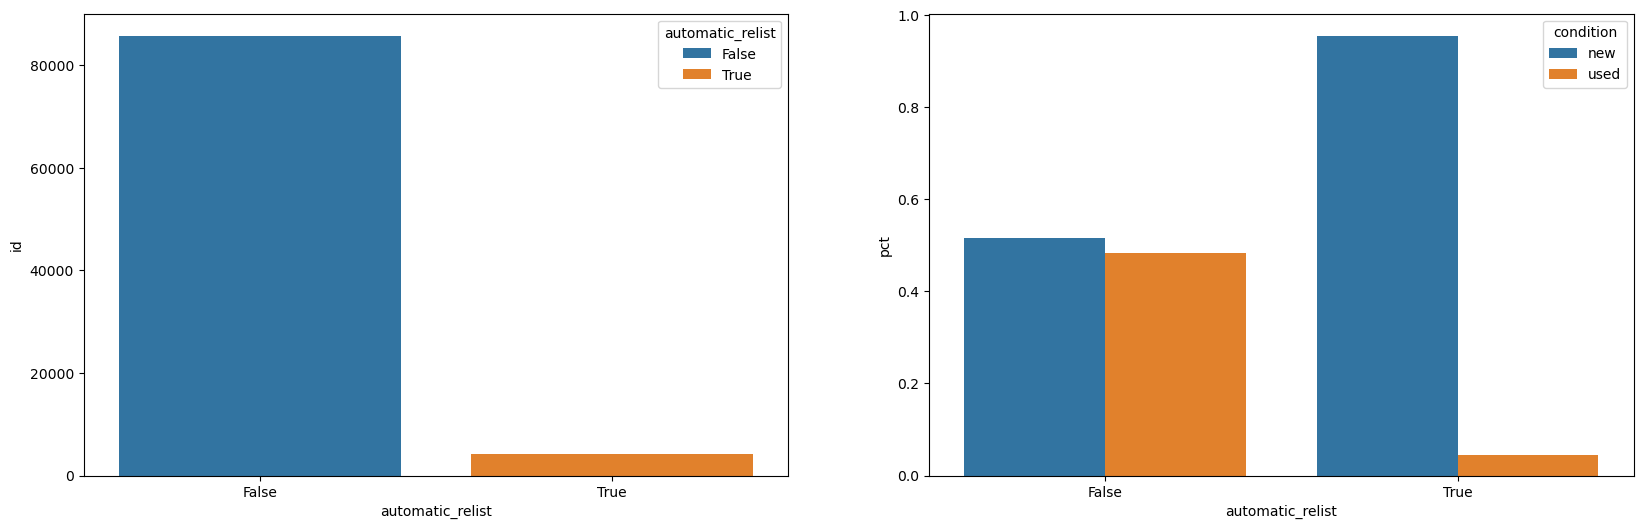

In [147]:
bar_plot_binarios(df_EDA,"automatic_relist","condition")
df_EDA["automatic_relist"] = df_EDA["automatic_relist"].astype(int)

**date_created**

inicialmente no se trata, eliminar. (Se puede compara con el last date updated)

In [148]:
df_EDA["date_created"].max()

'2015-10-15T09:14:30.000Z'

**status**

no se considera que la variable nos de mucho valor, desde una perspectiva de negocio. estas categorizaciones primero mas del 94% tiene el valor activo y segundo estos cambios de estado se pueden dar una vez publicado el anuncio y no obedecen a caracteristicas del producto si no de la publicacion

0


,status,id,pct
0,active,86116,0.956844
1,closed,20,0.000222
2,not_yet_active,1,0.000011
3,paused,3863,0.042922


,status,condition,id,pct
0,active,new,45712,0.530819
1,active,used,40404,0.469181
2,closed,new,9,0.450000
3,closed,used,11,0.550000
4,not_yet_active,new,1,1.000000
5,paused,new,2630,0.680818
6,paused,used,1233,0.319182


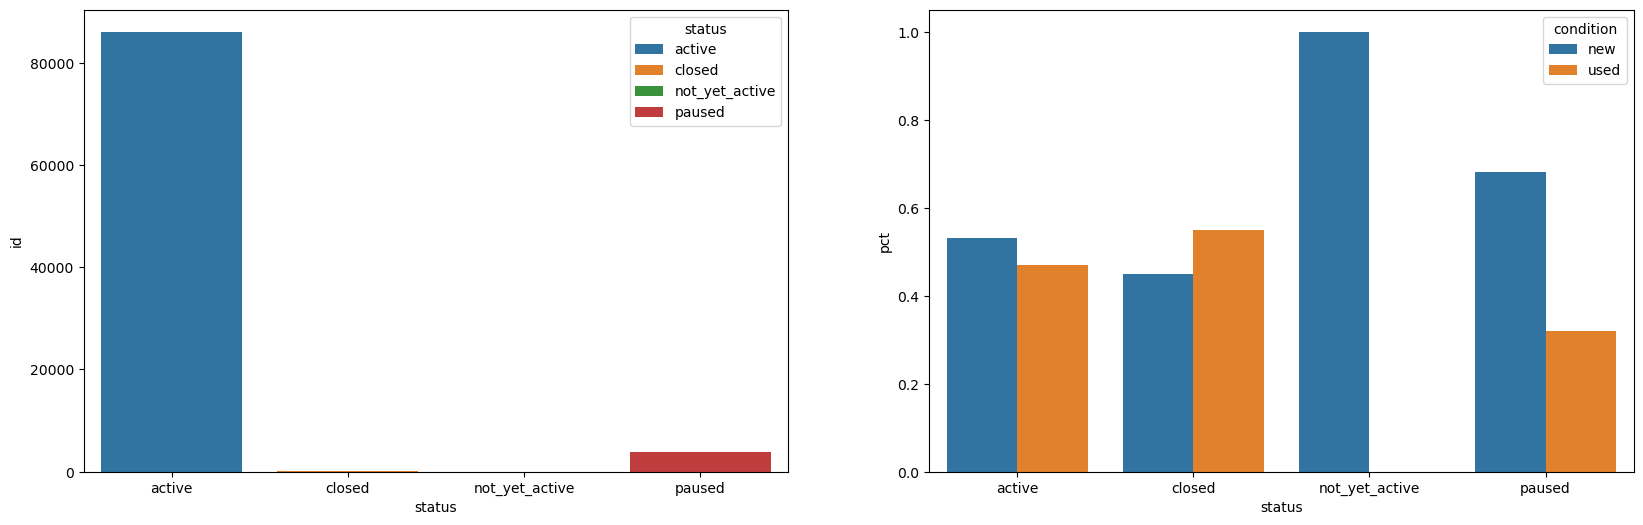

In [149]:
col = "status"
print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

**video_id**

ya fue transformada arriba, se binarizo

,video_id,id,pct
0,0,87324,0.970267
1,1,2676,0.029733


,video_id,condition,id,pct
0,0,new,46287,0.530060
1,0,used,41037,0.469940
2,1,new,2065,0.771674
3,1,used,611,0.228326


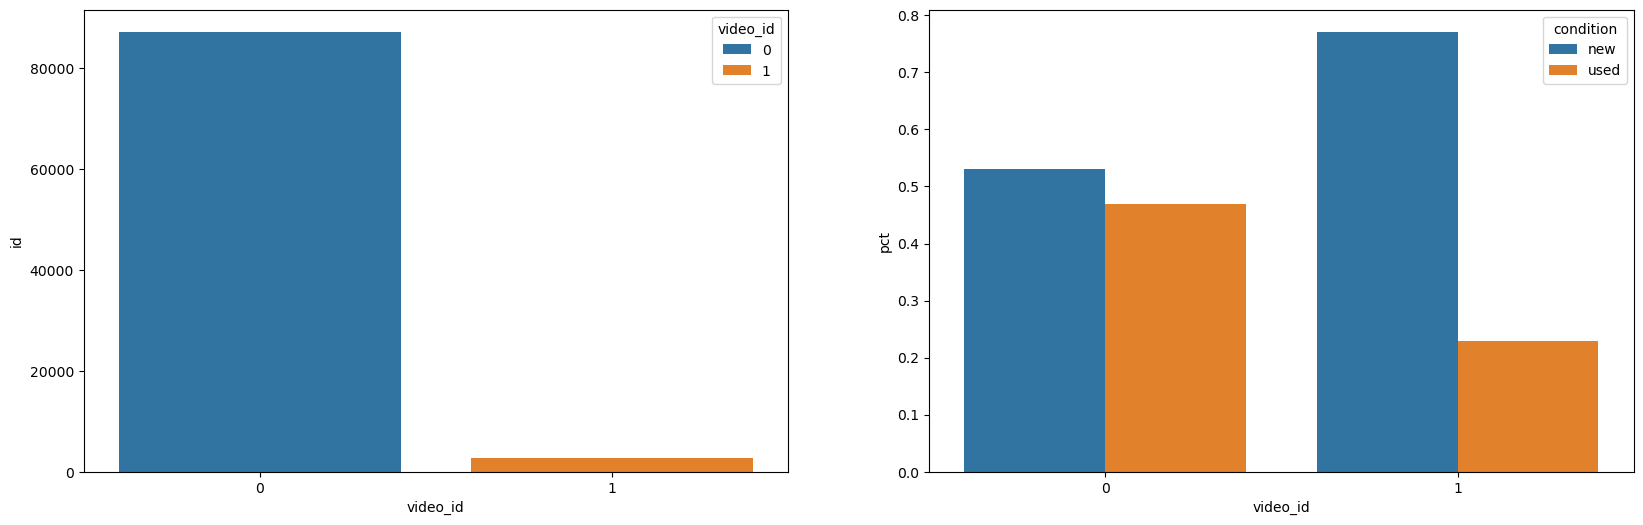

In [150]:
bar_plot_binarios(df_EDA,"video_id","condition")

**initial_quantity**

se mantiene la variable sin transformaciones incialmente

0


,count,mean,std,min,25%,50%,75%,max
initial_quantity,90000.0,34.957178,421.091981,1.0,1.0,1.0,2.0,9999.0


initial_quantity                                                   
                     count       mean         std  min  25%  50%  75%     max
condition                                                                    
new                48352.0  63.265201  570.433371  1.0  1.0  2.0  9.0  9999.0
used               41648.0   2.092465   58.313104  1.0  1.0  1.0  1.0  9999.0

C:\Users\Paul\AppData\Local\Temp\ipykernel_7436\2415066710.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.         4.60517019 0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_dummy.loc[:,col] = np.log(df_dummy[col])


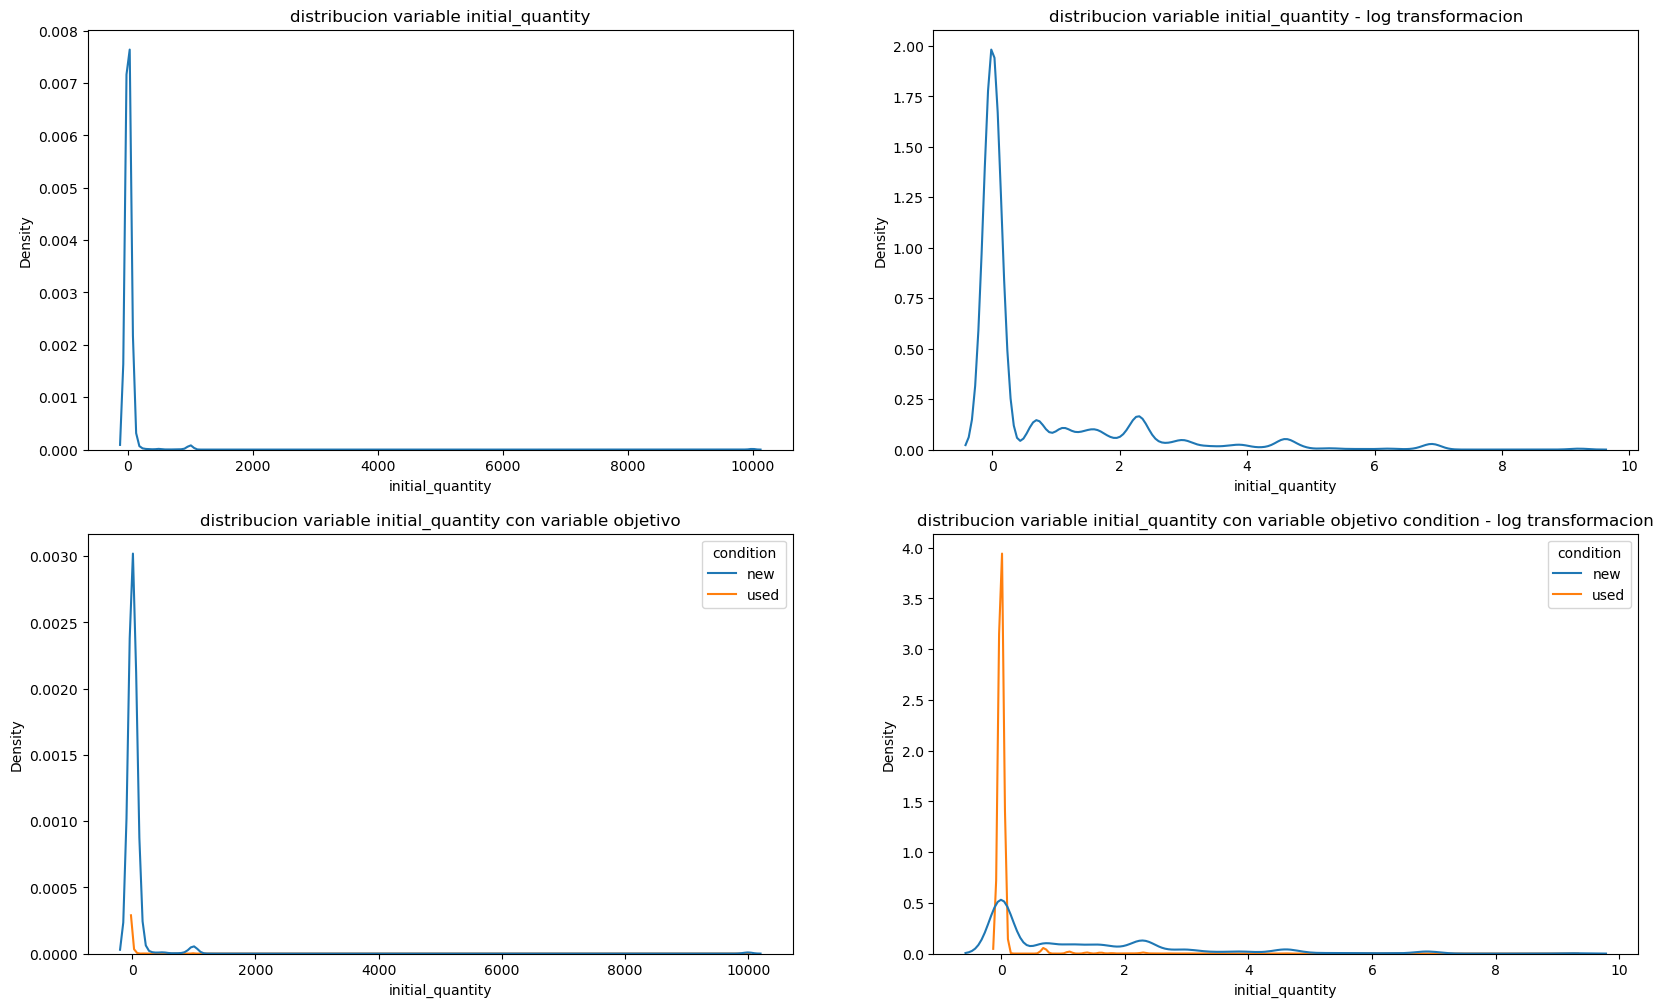

In [151]:
desc_continuous(df_EDA,"initial_quantity","condition")

**sold_quantity**

se mantiene la variable sin transformar

0


,count,mean,std,min,25%,50%,75%,max
sold_quantity,90000.0,2.328044,33.839328,0.0,0.0,0.0,0.0,6065.0


sold_quantity                                                 
                  count      mean        std  min  25%  50%  75%     max
condition                                                               
new             48352.0  4.249318  45.848825  0.0  0.0  0.0  1.0  6065.0
used            41648.0  0.097508   4.979905  0.0  0.0  0.0  0.0   982.0

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Paul\AppData\Local\Temp\ipykernel_7436\2415066710.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-inf -inf -inf ... -inf -inf -inf]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_dummy.loc[:,col] = np.log(df_dummy[col])


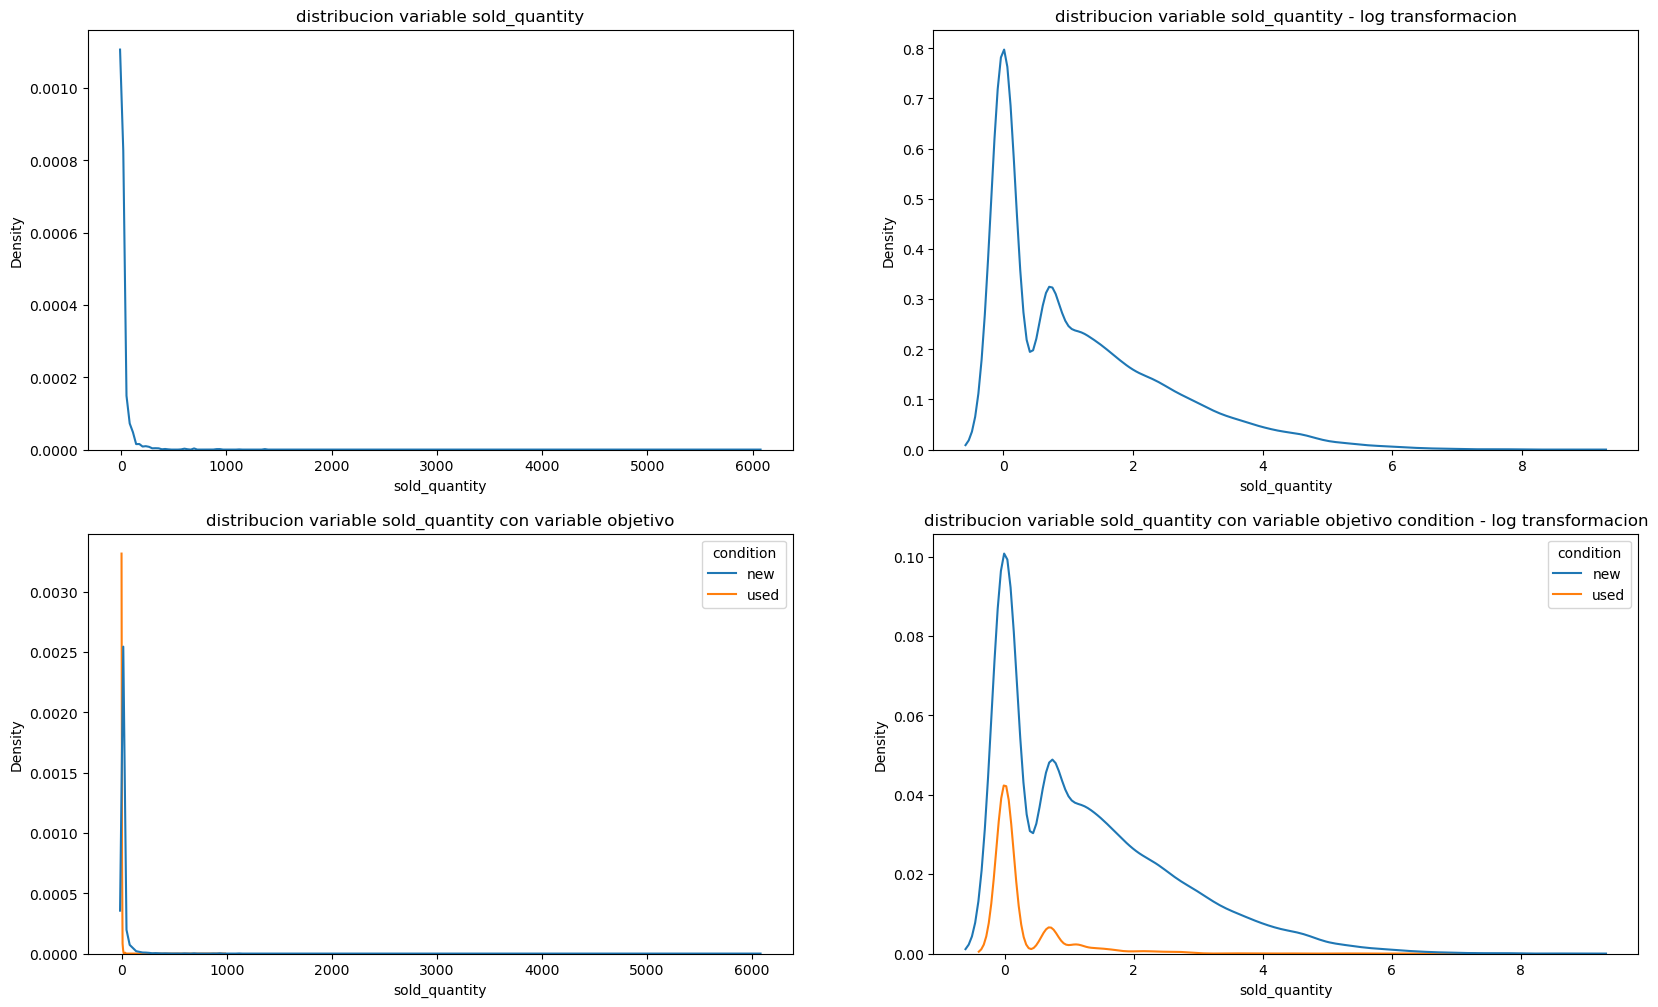

In [152]:
desc_continuous(df_EDA,"sold_quantity","condition")

**available_quantity**

mantener

0


,count,mean,std,min,25%,50%,75%,max
available_quantity,90000.0,34.700767,420.811703,1.0,1.0,1.0,2.0,9999.0


available_quantity                                             \
                       count       mean         std  min  25%  50%  75%   
condition                                                                 
new                  48352.0  62.807578  570.079551  1.0  1.0  2.0  9.0   
used                 41648.0   2.069655   58.201952  1.0  1.0  1.0  1.0   

                   
              max  
condition          
new        9999.0  
used       9999.0

C:\Users\Paul\AppData\Local\Temp\ipykernel_7436\2415066710.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.         4.60517019 0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_dummy.loc[:,col] = np.log(df_dummy[col])


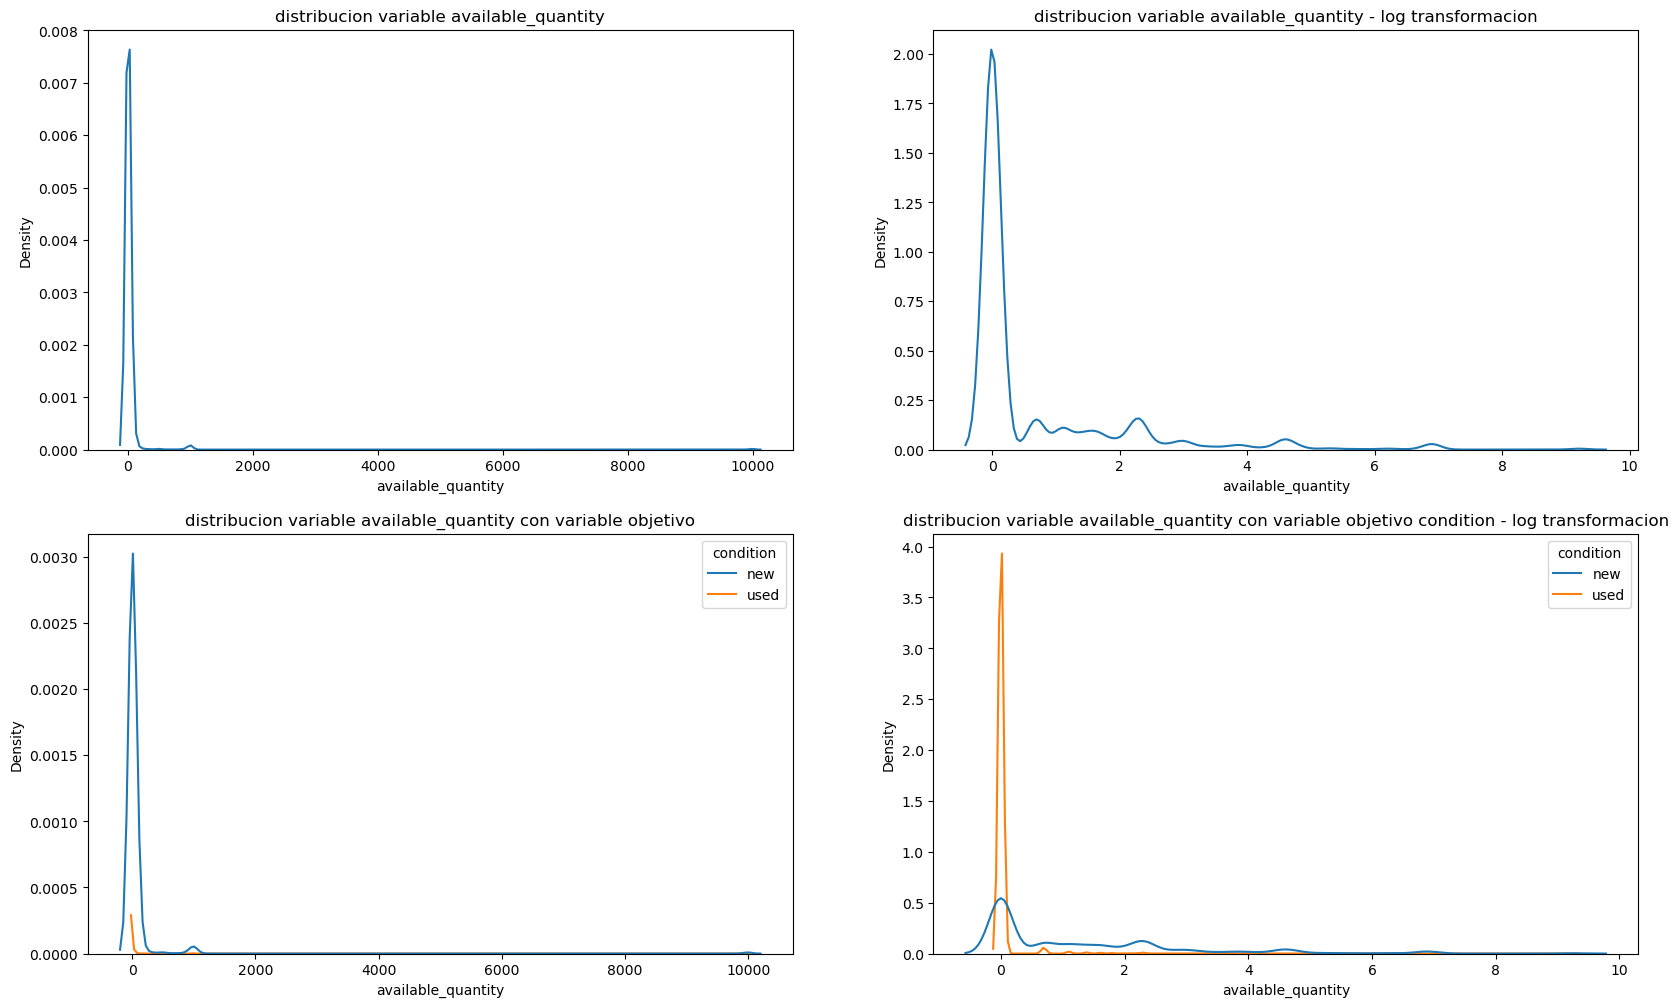

In [153]:
desc_continuous(df_EDA,"available_quantity","condition")

**seller_address_country_name**

solo hay un dato vacio y el resto corresponde a un unico pais, por lo que se elmina la variable

0


,seller_address_country_name,id,pct
0,,1,0.000011
1,Argentina,89999,0.999989


,seller_address_country_name,condition,id,pct
0,,used,1,1.00000
1,Argentina,new,48352,0.53725
2,Argentina,used,41647,0.46275


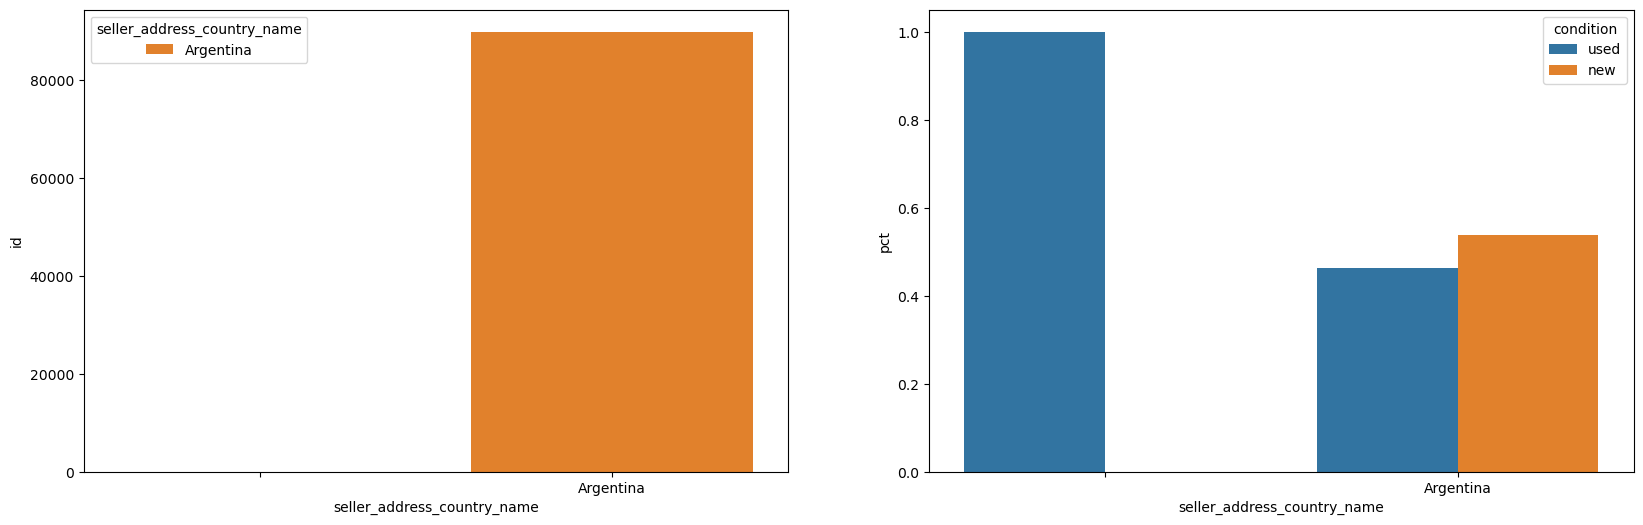

In [154]:
col = "seller_address_country_name"
print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

**seller_address_country_id**

mismo que country name

0


,seller_address_country_id,id,pct
0,,1,0.000011
1,AR,89999,0.999989


,seller_address_country_id,condition,id,pct
0,,used,1,1.00000
1,AR,new,48352,0.53725
2,AR,used,41647,0.46275


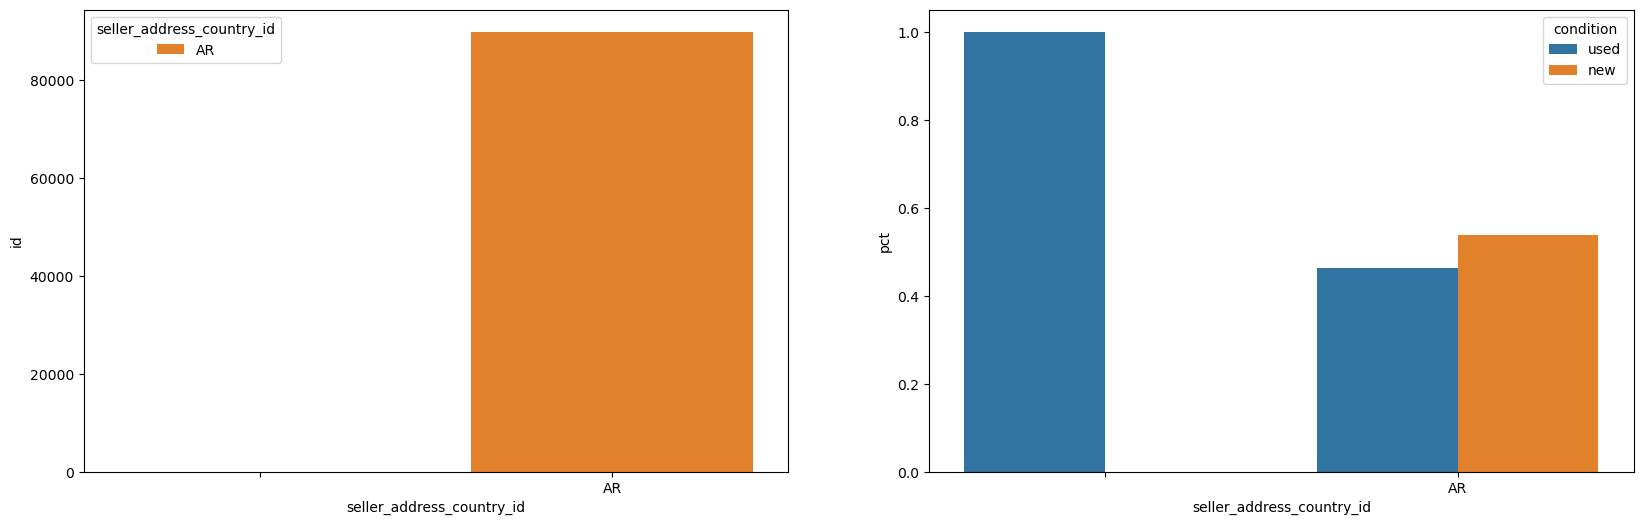

In [155]:
col = "seller_address_country_id"
print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

**seller_address_state_name**

se manejara de forma binaria para indicar los productos que no esten en Buenos Aires que se asume tambien es la capital Federal

0


,seller_address_state_name,id,pct
0,,1,0.000011
1,Buenos Aires,31482,0.349800
2,Capital Federal,52143,0.579367
3,Catamarca,20,0.000222
4,Chaco,69,0.000767
5,Chubut,335,0.003722
6,Corrientes,110,0.001222
7,Córdoba,1727,0.019189
8,Entre Ríos,249,0.002767
9,Formosa,28,0.000311


,seller_address_state_name,condition,id,pct
0,,used,1,1.000000
1,Buenos Aires,new,16578,0.526587
2,Buenos Aires,used,14904,0.473413
3,Capital Federal,new,28060,0.538136
4,Capital Federal,used,24083,0.461864
5,Catamarca,new,18,0.900000
6,Catamarca,used,2,0.100000
7,Chaco,new,38,0.550725
8,Chaco,used,31,0.449275
9,Chubut,new,274,0.817910


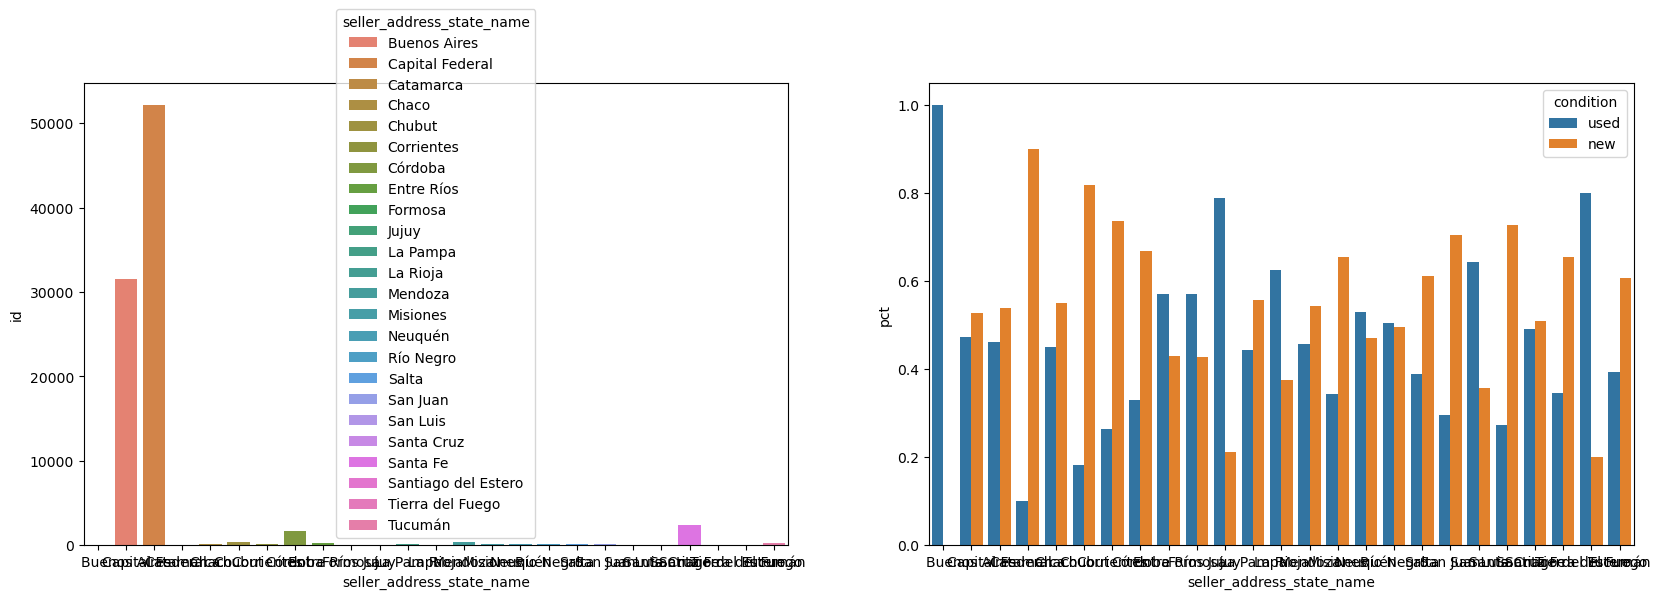

In [156]:
col = "seller_address_state_name"
print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

In [157]:
df_EDA["flg_is_capital_city"] = df_EDA["seller_address_state_name"].str.lower().isin(["capital federal", "buenos aires"]).astype(int)

**seller_address_state_id**

se elimina ya que se decide enriquecer la variable seller_address_state_name

**seller_address_city_name - seller_address_city_id**

ya se tomo la variable estado, y no se considera que la granularidad de la ciudad aporte al modelo

In [158]:
print(df_EDA["seller_address_city_name"].nunique())

df_EDA.groupby("seller_address_city_name")[["id"]].count().sort_values(by="id",ascending=False)/df_EDA.shape[0]

3480


,id
seller_address_city_name,
CABA,0.041200
Buenos Aires,0.034489
Capital Federal,0.033922
Palermo,0.033278
Caballito,0.029722
...,...
"Vicente Lopez, Florida",0.000011
"Vicente Lopez, Buenos Aires",0.000011
Vicente Lopez Munro,0.000011


**shipping_local_pick_up**

se convierte a numerica la variable

0


,shipping_local_pick_up,id,pct
0,0,18423,0.2047
1,1,71577,0.7953


,shipping_local_pick_up,condition,id,pct
0,0,new,9138,0.496010
1,0,used,9285,0.503990
2,1,new,39214,0.547858
3,1,used,32363,0.452142


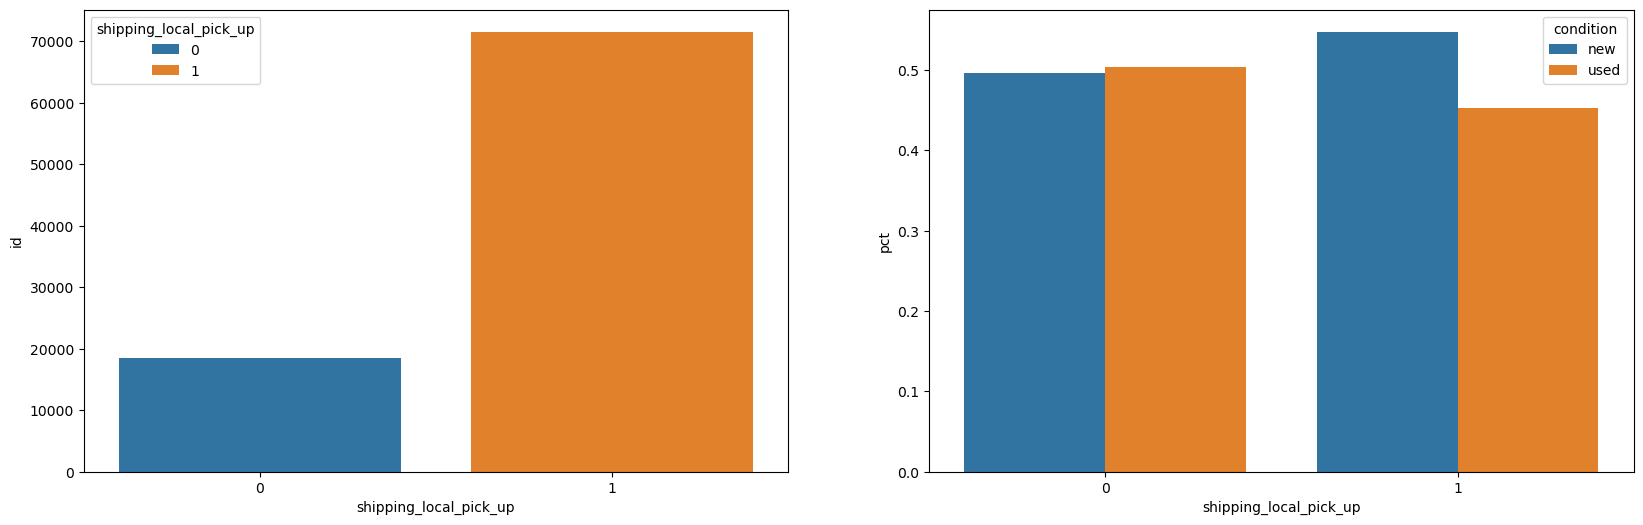

In [159]:
col = "shipping_local_pick_up"

df_EDA[col] = df_EDA[col].astype(int)

print(df_EDA[col].isna().sum())
bar_plot_binarios(df_EDA,col,"condition")

**shipping_methods**

esta vacio se elimina

In [160]:
cantidad_distintos_nulo(df_EDA,"shipping_methods")
valida_contenido_json(df_EDA,"shipping_methods")

valores distintos de null: 87310
porcentaje de no nulos: 0.9701111111111111
cantidad de elementos con datos 0
porcentaje de elemetos con datos 0.0


**shipping_tags**

porcentaje insignificante de la base, no aporta valor al modelo. Eliminar

In [161]:
cantidad_distintos_nulo(df_EDA,"shipping_tags")
valida_contenido_json(df_EDA,"shipping_tags")

valores distintos de null: 90000
porcentaje de no nulos: 1.0
cantidad de elementos con datos 59
porcentaje de elemetos con datos 0.0006555555555555556


**shipping_free_shipping**

se transforma a variable numerica donde indica que 1 tiene free shipping y 0 de lo contrario

valores distintos de null: 90000
porcentaje de no nulos: 1.0


,shipping_free_shipping,id,pct
0,0,87303,0.970033
1,1,2697,0.029967


,shipping_free_shipping,condition,id,pct
0,0,new,45851,0.525194
1,0,used,41452,0.474806
2,1,new,2501,0.927327
3,1,used,196,0.072673


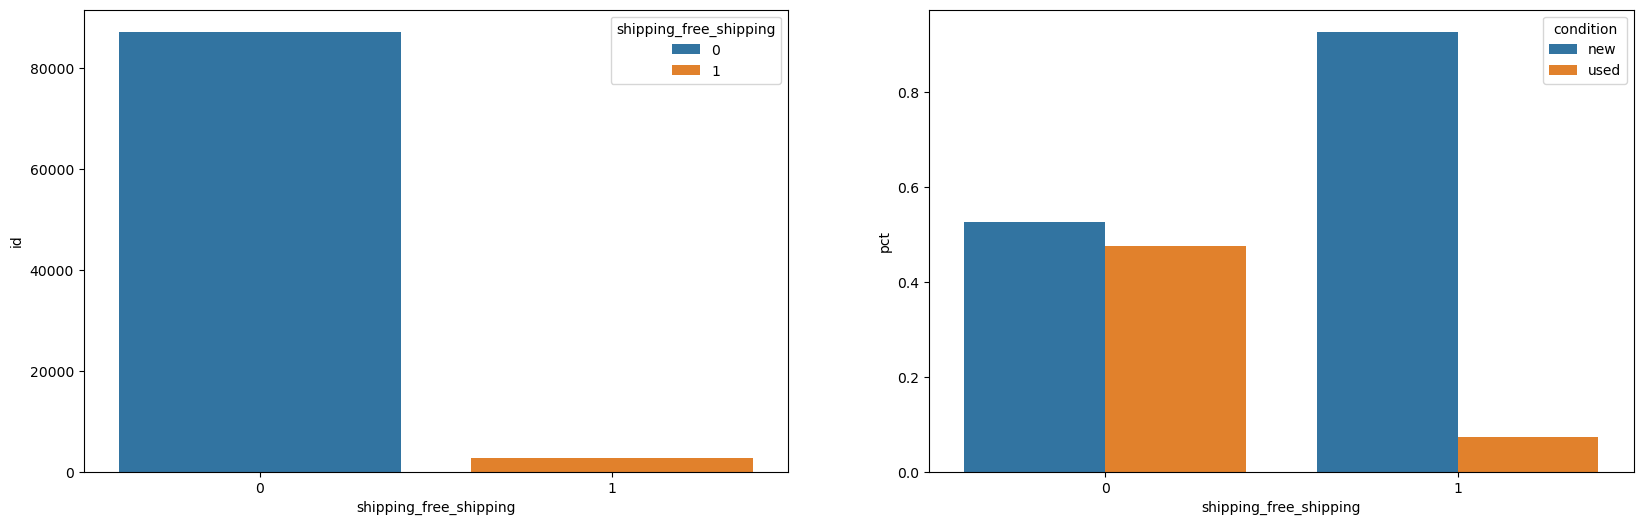

In [162]:
col = "shipping_free_shipping"

df_EDA[col] = df_EDA[col].astype(int)

cantidad_distintos_nulo(df_EDA,col)
bar_plot_binarios(df_EDA,col,"condition")

**shipping_mode**

https://developers.mercadolibre.com.ec/mercado-envios

- Mercado Envíos 1 (ME1): es una modalidad de envío que permite a los vendedores vender a través de Mercado Libre, utilizando su propia logística o servicios de terceros.
- Mercado Envíos 2 (ME2): es la modalidad de envío de Mercado Libre, donde se gestiona toda la logística utilizando diversos medios como correos, agencias, entre otros. Esta modalidad se divide a su vez en los siguiente tipos de logística:
    - Mercado Envíos Drop_off
    - Mercado Envíos Colectas (cross_docking) y Places (xd_drop_off)
    - Mercado Envíos Flex (self_service)
    - Mercado Envíos Turbo (turbo)
    - Mercado Envíos Full (fulfillment)
- Custom: es una modalidad de envío donde el vendedor carga una tabla con los precios de envío por cada región y se encarga de la logística.
- Not Specified: es una modalidad de envío donde el vendedor no especifica ningún precio de envío para sus publicaciones y debe ponerse en contacto con el comprador para coordinar el envío.

esta variable se transformara en binaria y sera un flg que cuando sea igual a not_specified = 1 de resto sera 0

valores distintos de null: 90000
porcentaje de no nulos: 1.0


,shipping_mode,id,pct
0,custom,3130,0.034778
1,me1,86,0.000956
2,me2,46059,0.511767
3,not_specified,40725,0.452500


,shipping_mode,condition,id,pct
0,custom,new,2107,0.673163
1,custom,used,1023,0.326837
2,me1,new,86,1.000000
3,me2,new,26277,0.570507
4,me2,used,19782,0.429493
5,not_specified,new,19882,0.488201
6,not_specified,used,20843,0.511799


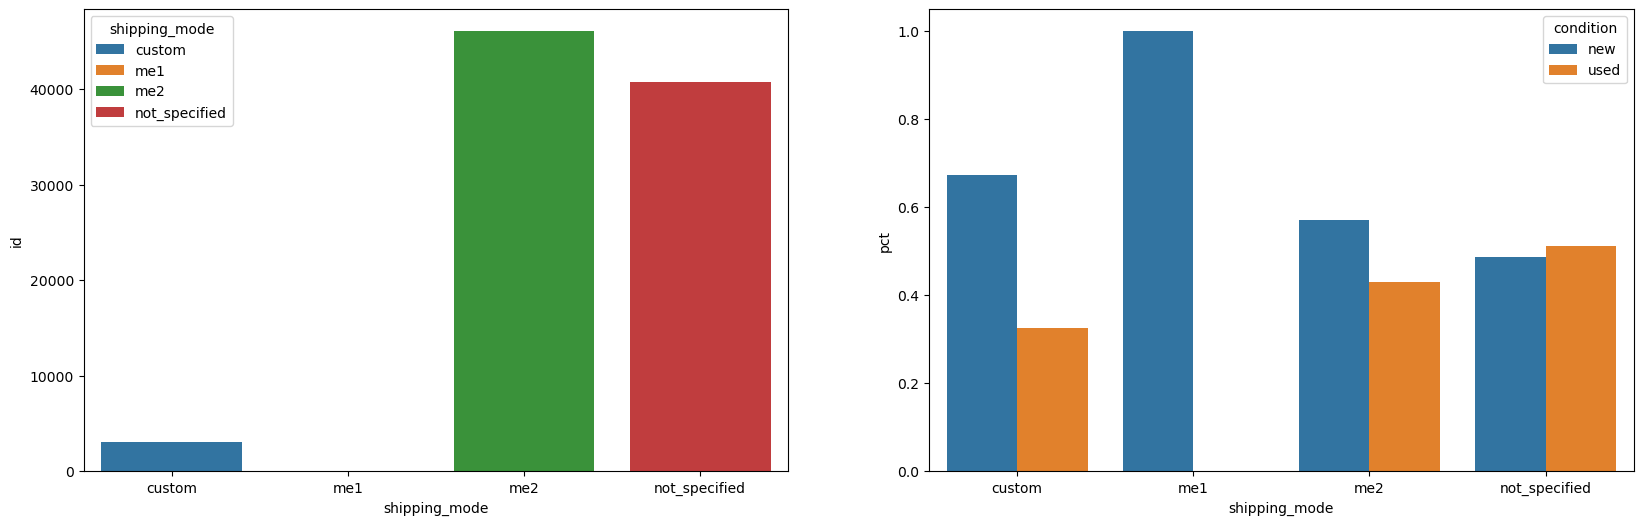

In [163]:
cantidad_distintos_nulo(df_EDA,"shipping_mode")
bar_plot_binarios(df_EDA,"shipping_mode","condition")

**shipping dimensions**

la variable fue tratada arriba y se decidio eliminar

**shipping_free_methods**

Se transforma a binaria la variable, luego de explorar la informacion y determinar que no vale la pena ahondar en las caracteristicas del json contenido. se mantiene entonces el valor de la cantidad de shipping free methods

In [164]:
cantidad_distintos_nulo(df_EDA,"shipping_free_methods")
valida_contenido_json(df_EDA,"shipping_free_methods")
explore_json_column(df_EDA,"shipping_free_methods")

valores distintos de null: 2689
porcentaje de no nulos: 0.029877777777777777
cantidad de elementos con datos 2689
porcentaje de elemetos con datos 0.029877777777777777
2689


,id,rule.value,rule.free_mode
0,73328,None,country
1,73328,None,country
2,73328,None,country
3,73328,None,country
4,73328,None,country
...,...,...,...
2685,73328,None,country
2686,73328,None,country
2687,73328,None,country
2688,73328,None,country


In [165]:
c_test = df_EDA["shipping_free_methods"].str.len() > 0
df_EDA.loc[:,"shipping_free_methods"].str.len().fillna(0).unique()

array([0., 1., 2.])

,shipping_free_methods,id,pct
0,0.0,87311,0.970122
1,1.0,2688,0.029867
2,2.0,1,0.000011


,shipping_free_methods,condition,id,pct
0,0.0,new,45858,0.525226
1,0.0,used,41453,0.474774
2,1.0,new,2493,0.927455
3,1.0,used,195,0.072545
4,2.0,new,1,1.000000


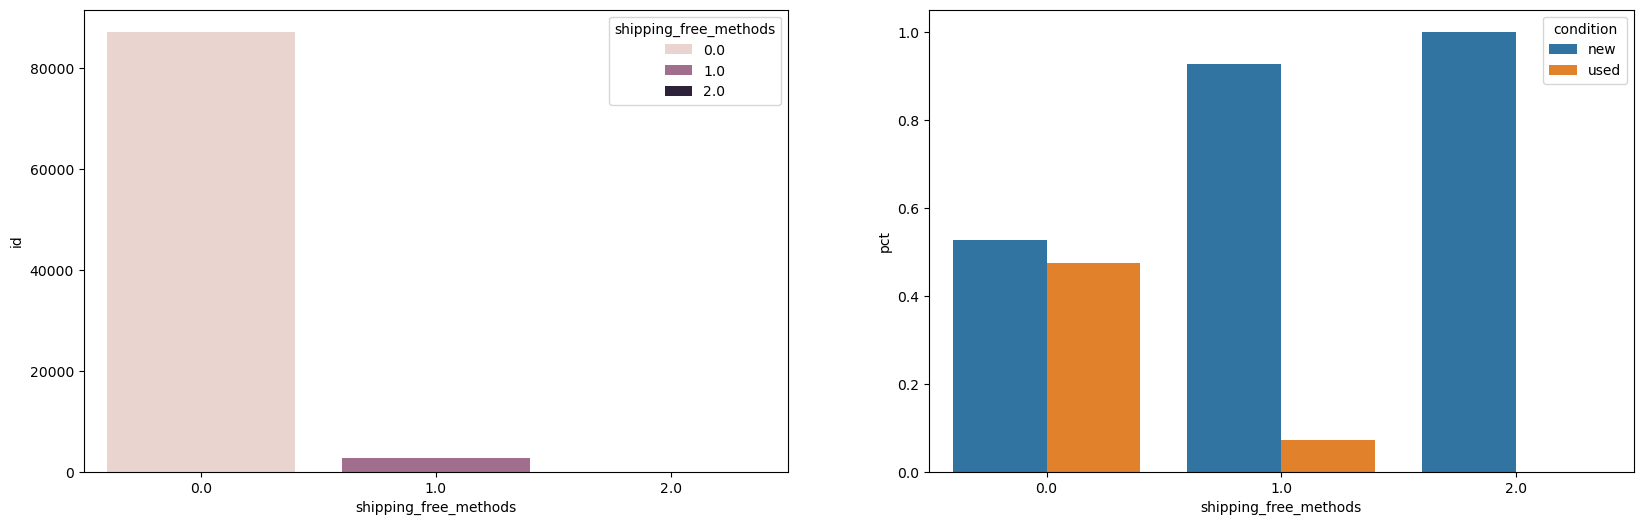

In [166]:
df_EDA["shipping_free_methods"] = df_EDA.loc[:,"shipping_free_methods"].str.len().fillna(0)

bar_plot_binarios(df_EDA,"shipping_free_methods","condition")

# Aplicar las transformaciones

In [167]:
def drop_cols(df,lst_cols):
    drop_df = df.drop(columns=lst_cols)
    return drop_df

def to_binary_exists(df,cols):
    df[cols] = (~df[cols].isna()).astype(int)
    return df

def to_binary_boolean_to_numeric(df,cols):
    df[cols] = df[cols].astype(int).fillna(0)
    return df


def to_binary_exists_json(df,cols):
    
    df[cols] = df[cols].apply(lambda x : (x.str.len().fillna(0) > 0).astype(int))
    return df

def to_binary_str_is_in(df,dict_transform):

    for k,v in dict_transform.items():
        df["flg_{}_{}".format(k,v)] = df[k].isin([v]).astype(int).fillna(0)
    
    df.drop(columns=dict_transform.keys(), inplace=True)

    return df

def to_binary_location(df,dict_transform):

    for k,v in dict_transform.items():
        df["flg_{}".format(v[0])] = df[k].isin(v[1]).astype(int)
    
    df.drop(columns=dict_transform.keys(), inplace=True)

    return df


def transform_base_price(df):
    df["variation_base_price"] = (np.sign(df["price"]  - df["base_price"])).fillna(0)
    df.drop(columns=["base_price"], inplace=True)
    return df

def transform_original_price(df):

    df["variation_original_price"] = (np.sign(df["price"]  - df["original_price"])).fillna(0)
    df.drop(columns = ["original_price"], inplace=True)
    return df

def transform_num_elements_json(df,col,new_name):
    df[new_name] = df[col].str.len().fillna(0)
    df.drop(columns = [col], inplace=True)
    return df

def transform_payment_methods(df):
    dict_metodos_de_pago = {
        "Acordar con el comprador": "efectivo_o_acuerdo",
        "Efectivo": "efectivo_o_acuerdo",
        "Transferencia bancaria": "transferencia_bancaria",
        "Giro postal": "giro_postal",
        "Cheque certificado": "cheque",
        "American Express": "tarjeta_credito",
        "Diners": "tarjeta_credito",
        "MasterCard": "tarjeta_credito",
        "Mastercard Maestro": "tarjeta_credito",
        "Visa": "tarjeta_credito",
        "Visa Electron": "tarjeta_credito",
        "Tarjeta de crédito": "tarjeta_credito",
        "MercadoPago": "MercadoPago",
        "Contra reembolso": "contra_reembolso"
    }
    
    df_payment_methods = df.loc[:,["id","non_mercado_pago_payment_methods"]].\
                            explode("non_mercado_pago_payment_methods").\
                            reset_index()

    df_payment_methods_explode = pd.json_normalize(df_payment_methods["non_mercado_pago_payment_methods"])
    df_payment_methods_explode.rename(columns={"description":"description_shipping_free_methods",
                                                    "id":"id_shipping_free_methods"},
                                            inplace=True)

    df_payment_methods = pd.concat([df_payment_methods[["id"]], 
                                        df_payment_methods_explode], 
                                        axis=1)[["id","description_shipping_free_methods","id_shipping_free_methods"]]
    

    df_payment_methods["metodo_de_pago"] = df_payment_methods["description_shipping_free_methods"].map(dict_metodos_de_pago)
    df_payment_methods["ones"] = 1
    gr_df_payment_methods = df_payment_methods.groupby(["id","metodo_de_pago"])[["ones"]].sum().reset_index()
    gr_df_payment_methods = gr_df_payment_methods.pivot(index="id",columns="metodo_de_pago", values="ones").fillna(0)

    transform_num_elements_json(df,"non_mercado_pago_payment_methods","num_payment_methods")

    df = pd.merge(df, gr_df_payment_methods, on="id", how="left").fillna(0)
    df.loc[:,gr_df_payment_methods.columns.values] = df[gr_df_payment_methods.columns.values].fillna(0)

    return df


def transform_ini_seller_id(df):
    df["binary_used"] = (df["condition"] == "used").astype(int)

    gr_seller_id = df.groupby(["seller_id"]).agg({"binary_used":"sum","id":"count"})
    gr_seller_id["score_seller_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]

    dict_return = gr_seller_id[["score_seller_used"]].to_dict()["score_seller_used"]

    df.drop(columns=["binary_used"], inplace = True)

    return dict_return


def transform_seller_id(df,dict_param):

    df["score_seller"] = df["seller_id"].map(dict_param).fillna(0)
    df.drop(columns=["seller_id"], inplace=True)

    return df


def transform_ini_category_id_popularity(df, drop=True):
    df["binary_used"] = (df["condition"] == "used").astype(int)

    gr_seller_id = df.groupby(["category_id"]).agg({"binary_used":"sum","id":"count"})
    gr_seller_id["score_category_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]

    dict_return = gr_seller_id[["score_category_used"]].to_dict()["score_category_used"]

    if drop:
        df.drop(columns=["binary_used"], inplace = True)

    return dict_return


def transform_category_id_popularity(df,dict_param):

    df["score_popularity_category"] = df["category_id"].map(dict_param).fillna(0)
    df.drop(columns=["category_id"], inplace=True)

    return df


def transform_listing_type(df):

    dict_transform_listing_type = {'free':0,
                               'bronze':1,
                               'silver':2,
                               'gold':3, 
                               'gold_premium':4,
                               'gold_special':5, 
                               'gold_pro':6}
    
    df["listing_type_id"] = df["listing_type_id"].map(dict_transform_listing_type).fillna(0)

    return df


def transform_ini_category_id(df):

    gr_category_id = df.groupby("category_id")[["id"]].count().sort_values("id",ascending=False)
    gr_category_id = gr_category_id/gr_category_id.max()

    dict_transform = gr_category_id.to_dict()["id"]

    return dict_transform


def transform_category_id(df,dict_transform, drop = True):

    df["score_category_id"] = df["category_id"].map(dict_transform).fillna(0)
    if drop:
        df.drop(columns = ["category_id"], inplace=True)
    return df

def init_identify_outliers(df,list_columns):
    
    dict_param_outliers = {}
    for column in list_columns:
    
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        dict_param_outliers[column] = [lower_bound,upper_bound]
    
    return dict_param_outliers

def identify_outliers(df, column, dict_params):

    # Define lower and upper bounds for outliers
    lower_bound, upper_bound = dict_params[column]
    
    # Identify outliers as 1, non-outliers as 0
    df["flg_outliers_{}".format(column)] = ((df[column] < lower_bound) | (df[column] > upper_bound)).astype(int)
    
    return df


def transform_X(df, dict_transform_seller_id, dict_transform_category_id, dict_transform_category_id_popularity, dict_param_outliers, cols_transform_outliers):
    

    lst_drop_cols = ["sub_status",
                 "deal_ids",
                 "site_id",
                 "listing_source",
                 "coverage_areas",
                 "descriptions",
                 "last_updated",
                 "international_delivery_mode",
                 "differential_pricing",
                 "currency_id",
                 "thumbnail",
                 "title",
                 "date_created",
                 "secure_thumbnail",
                 "stop_time",
                 "status",
                 "catalog_product_id",
                 "subtitle",
                 "start_time",
                 "permalink",
                 "seller_address_country_name",
                 "seller_address_country_id",
                 "seller_address_state_id",
                 "seller_address_city_name",
                 "seller_address_city_id",
                 "shipping_methods",
                 "shipping_tags",
                 "shipping_dimensions"
                 ]
    
    lst_binary_exists = ["warranty",
                         "parent_item_id", 
                         "official_store_id",
                         "video_id"
                         ]
    
    lst_binary_boolean_to_numeric = ["accepts_mercadopago", 
                                     "automatic_relist", 
                                     "shipping_local_pick_up",
                                     "shipping_free_shipping"
                                    ]
    

    dict_transform_str_is_in = {"buying_mode":"buy_it_now",
                                "shipping_mode":"not_specified"}


    dict_transform_location = {"seller_address_state_name":["flg_is_capital_city",["capital federal", "buenos aires"]]}

    dict_transform_num_elements = {
        "variations": "num_variations",
        "attributes": "num_attributes",
        "tags":"num_tags",
        "pictures": "num_pictures",
        "shipping_free_methods":"num_shipping_free_methods"
    }

    df = drop_cols(df,lst_drop_cols)
    df = to_binary_exists(df, lst_binary_exists)
    df = to_binary_boolean_to_numeric(df,lst_binary_boolean_to_numeric)
    df = to_binary_str_is_in(df,dict_transform_str_is_in)
    df = to_binary_location(df,dict_transform_location)

    
    for original_column, new_column in dict_transform_num_elements.items():
        df = transform_num_elements_json(df, original_column, new_column)

    df = transform_base_price(df)
    df = transform_original_price(df)
    
    df = transform_seller_id(df,dict_transform_seller_id)
    df = transform_listing_type(df)
    df = transform_category_id(df,dict_transform_category_id, drop=False)
    df = transform_category_id_popularity(df, dict_transform_category_id_popularity)
    df = transform_payment_methods(df)



    for x in cols_transform_outliers:
        df = identify_outliers(df,x,dict_param_outliers)


    return df

In [168]:
df_X_train = pd.json_normalize(X_train, sep='_')
df_X_test = pd.json_normalize(X_test, sep='_')


# incializa diccionarios de transformacion
cols_transform_outliers = ['price', 'initial_quantity', 'sold_quantity', 'available_quantity']

# funciones
dict_transform_seller_id = transform_ini_seller_id(df_X_train)
dict_transform_category_id = transform_ini_category_id(df_X_train)
dict_transform_category_id_popularity = transform_ini_category_id_popularity(df_X_train)
dict_param_outliers = init_identify_outliers(df_X_train,cols_transform_outliers)


df_X_train = transform_X(df_X_train,dict_transform_seller_id, dict_transform_category_id, dict_transform_category_id_popularity, dict_param_outliers, cols_transform_outliers)
df_X_test = transform_X(df_X_test,dict_transform_seller_id, dict_transform_category_id, dict_transform_category_id_popularity, dict_param_outliers, cols_transform_outliers)

df_X_train.set_index("id",inplace=True)
df_X_test.set_index("id",inplace=True)

Text(0.5, 1.0, 'grafica de correlacion de variables numericas')

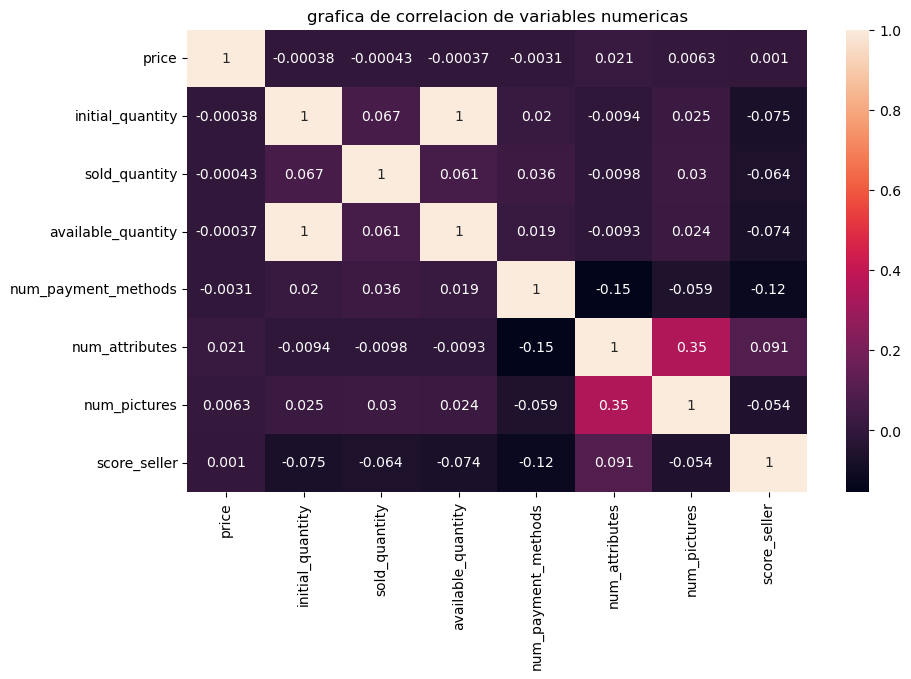

In [169]:
cols_numeric = ['price', 'initial_quantity', 'sold_quantity', 'available_quantity',       
       'num_payment_methods', 'num_attributes', 'num_pictures', 'score_seller']

cols_binary = [x for x in df.columns.values if x not in cols_numeric]

df_corr = df_X_train[cols_numeric].corr()
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_corr, annot=True, ax=ax)
ax.set_title("grafica de correlacion de variables numericas")

Alta correlacion entre **initial_quantity** y **available_quantity**, por lo que se eliminara la variable available_quantity y se creara un flag para determinar si los valores son iguales o no 

In [170]:
print("cantidad de valores iguales")
print(((df["initial_quantity"].fillna(0) - df["available_quantity"].fillna(0))==0).sum())
print("cantidad de valores distintos")
print(((df["initial_quantity"].fillna(0) - df["available_quantity"].fillna(0))!=0).sum())

cantidad de valores iguales
85983
cantidad de valores distintos
4017
